In [80]:
import os
import time
from datetime import datetime

import numpy as np
import pandas as pd
import scipy as sp
from tqdm import tqdm
from functools import partial

# import tensorflow as tf
# import tensorflow_probability as tfp

import vegas

import matplotlib.pyplot as plt
%matplotlib inline

In [81]:
def variance_weighted_result(means, stddevs):
    """ Computes weighted mean and stddev of given means and
        stddevs arrays, using Inverse-variance weighting
    """
    assert np.size(means) == np.size(stddevs)
    assert means.shape == stddevs.shape
    variance = 1./np.sum(1./stddevs**2, axis=-1)
    mean = np.sum(means/(stddevs**2), axis=-1)
    mean *= variance
    return mean, np.sqrt(variance)

In [82]:
NRUNS = 5

In [86]:
# result.mean — weighted average of all estimates of the integral;

# result.sdev — standard deviation of the weighted average;

# result.chi2 — \chi^2 of the weighted average;

# result.dof — number of degrees of freedom;

# result.Q — Q or p-value of the weighted average’s \chi^2;

# result.itn_results — list of the integral estimates from each iteration;

# result.sum_neval — total number of integrand evaluations used.

# result.avg_neval — average number of integrand evaluations per iteration

### F1 - simple gauss

In [160]:
import scipy.stats as spt

target = 1
target_precision = 1e-3

norm_dist = spt.norm(loc=0.5, scale=0.05)

prefix = 'f1'

target_dict = {
    'f1_d2': (norm_dist.cdf(1) - norm_dist.cdf(0)) ** 2,
    'f1_d4': (norm_dist.cdf(1) - norm_dist.cdf(0)) ** 4,
    'f1_d6': (norm_dist.cdf(1) - norm_dist.cdf(0)) ** 6,
    'f1_d8': (norm_dist.cdf(1) - norm_dist.cdf(0)) ** 8,
}
target_dict

{'f1_d2': 1.0, 'f1_d4': 1.0, 'f1_d6': 1.0, 'f1_d8': 1.0}

In [161]:
sigma = 0.05
alpha = sigma * np.sqrt(2)
pi = np.pi

def f1_np(x, ndims):
    pre = 1.0 / (alpha * np.sqrt(pi)) ** ndims
    exponent = -1 * np.sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * np.exp(exponent)

In [162]:
dim2func_dict = {
    2: partial(f1_np, ndims=2),
    4: partial(f1_np, ndims=4),
    6: partial(f1_np, ndims=6),
    8: partial(f1_np, ndims=8),
}
dim2func_dict

{2: functools.partial(<function f1_np at 0x00000212893CC438>, ndims=2),
 4: functools.partial(<function f1_np at 0x00000212893CC438>, ndims=4),
 6: functools.partial(<function f1_np at 0x00000212893CC438>, ndims=6),
 8: functools.partial(<function f1_np at 0x00000212893CC438>, ndims=8)}

#### Batch

In [163]:
sigma = 0.05
alpha = sigma * np.sqrt(2)
pi = np.pi

@vegas.batchintegrand
def f1_d2_np(x):
    pre = 1.0 / (alpha * np.sqrt(pi)) ** 2
    exponent = -1 * np.sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * np.exp(exponent)


@vegas.batchintegrand
def f1_d4_np(x):
    pre = 1.0 / (alpha * np.sqrt(pi)) ** 4
    exponent = -1 * np.sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * np.exp(exponent)


@vegas.batchintegrand
def f1_d6_np(x):
    pre = 1.0 / (alpha * np.sqrt(pi)) ** 6
    exponent = -1 * np.sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * np.exp(exponent)


@vegas.batchintegrand
def f1_d8_np(x):
    pre = 1.0 / (alpha * np.sqrt(pi)) ** 8
    exponent = -1 * np.sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * np.exp(exponent)

In [164]:
dim2func_dict = {
    2: f1_d2_np,
    4: f1_d4_np,
    6: f1_d6_np,
    8: f1_d8_np,
}
dim2func_dict

{2: <function __main__.f1_d2_np(x)>,
 4: <function __main__.f1_d4_np(x)>,
 6: <function __main__.f1_d6_np(x)>,
 8: <function __main__.f1_d8_np(x)>}

In [165]:
%%time
np.random.seed(123)

result_means = []
result_sdevs = []
result_times = []
result_avg_nevals = []
result_chi2_values = []
result_Q_values = []
result_run_nums = []

ndims_lst = [2,4,6,8]
neval_lst = list(map(int, [2e5]))
nitn_lst = list(map(int, [5]))
nhcube_batch_lst = list(map(int, [1e2, 1e3, 1e4, 1e5]))
run_lst = list(range(1,NRUNS+1))

for run in run_lst:
    print(f'run={run}')
    for ndims in ndims_lst:
        integrand = dim2func_dict[ndims]
        
        for nitn in nitn_lst:
            for neval in neval_lst:
                for nhcube_batch in nhcube_batch_lst:

                    print(f'ndims={ndims}  nitn={nitn}  neval={neval}  nhcube_batch={nhcube_batch}')

                    # using beta=0 to get maximum number of hypercubes
                    integ = vegas.Integrator([[0, 1]] * ndims, nhcube_batch=nhcube_batch, beta=0)

                    time_a = time.time()
                    current_result = integ(integrand, nitn=nitn, neval=neval, beta=0)
                    total_time = time.time() - time_a

                    result_means.append(current_result.mean)
                    result_sdevs.append(current_result.sdev)
                    result_times.append(total_time)
                    result_avg_nevals.append(current_result.avg_neval)
                    result_chi2_values.append(current_result.chi2)
                    result_Q_values.append(current_result.Q)
                    result_run_nums.append(run)

run=1
ndims=2  nitn=5  neval=200000  nhcube_batch=100
ndims=2  nitn=5  neval=200000  nhcube_batch=1000
ndims=2  nitn=5  neval=200000  nhcube_batch=10000
ndims=2  nitn=5  neval=200000  nhcube_batch=100000
ndims=4  nitn=5  neval=200000  nhcube_batch=100
ndims=4  nitn=5  neval=200000  nhcube_batch=1000
ndims=4  nitn=5  neval=200000  nhcube_batch=10000
ndims=4  nitn=5  neval=200000  nhcube_batch=100000
ndims=6  nitn=5  neval=200000  nhcube_batch=100
ndims=6  nitn=5  neval=200000  nhcube_batch=1000
ndims=6  nitn=5  neval=200000  nhcube_batch=10000
ndims=6  nitn=5  neval=200000  nhcube_batch=100000
ndims=8  nitn=5  neval=200000  nhcube_batch=100
ndims=8  nitn=5  neval=200000  nhcube_batch=1000
ndims=8  nitn=5  neval=200000  nhcube_batch=10000
ndims=8  nitn=5  neval=200000  nhcube_batch=100000
run=2
ndims=2  nitn=5  neval=200000  nhcube_batch=100
ndims=2  nitn=5  neval=200000  nhcube_batch=1000
ndims=2  nitn=5  neval=200000  nhcube_batch=10000
ndims=2  nitn=5  neval=200000  nhcube_batch=10000

In [166]:
temp_df = pd.DataFrame({
    'ndims':        sorted(ndims_lst * len(nitn_lst) * len(neval_lst) * len(nhcube_batch_lst)) * len(run_lst),
    'nitn':         sorted(nitn_lst * len(neval_lst) * len(nhcube_batch_lst)) * len(ndims_lst) * len(run_lst),
    'neval':        sorted(neval_lst * len(nhcube_batch_lst)) * len(nitn_lst) * len(ndims_lst) * len(run_lst),
    'nhcube_batch': sorted(nhcube_batch_lst) * len(neval_lst) * len(nitn_lst) * len(ndims_lst) * len(run_lst),
    'result_mean':  result_means,
    'result_sdev':  result_sdevs,
    'total_time':   result_times,
    'avg_neval':    result_avg_nevals,
    'chi2':         result_chi2_values,
    'Q':            result_Q_values,
    'run_num':      result_run_nums,
})

In [167]:
temp_df

,ndims,nitn,neval,nhcube_batch,result_mean,result_sdev,total_time,avg_neval,chi2,Q,run_num
0,2,5,200000,100,0.999982,0.000014,0.454782,199712,7.324056,1.197227e-01,1
1,2,5,200000,1000,0.999987,0.000015,0.207446,199712,0.872844,9.284241e-01,1
2,2,5,200000,10000,0.999995,0.000015,0.179520,199712,1.279470,8.648490e-01,1
3,2,5,200000,100000,0.999971,0.000015,0.202459,199712,6.606256,1.582173e-01,1
4,4,5,200000,100,1.001003,0.000513,0.541551,198288,3.598048,4.631278e-01,1
...,...,...,...,...,...,...,...,...,...,...,...
75,6,5,200000,100000,1.004368,0.003825,0.356048,172872,3.361298,4.992792e-01,5
76,8,5,200000,100,0.956021,0.019754,0.594410,163840,18.351695,1.053297e-03,5
77,8,5,200000,1000,0.803614,0.014949,0.387962,163840,517.351563,1.182952e-110,5
78,8,5,200000,10000,0.968391,0.023544,0.396939,163840,7.856720,9.696999e-02,5


In [172]:
prefix

'f1'

In [168]:
os.makedirs('result/03_Vegas', exist_ok=True)
temp_df.to_csv(f'result/03_Vegas/{prefix}_batch.csv', index=False)

In [169]:
# temp_df = pd.read_csv(f'result/03_Vegas/{prefix}_batch.csv')

In [170]:
g_temp_df = temp_df.groupby(['ndims', 'nitn', 'neval', 'nhcube_batch'], as_index=False)
g_temp_df = g_temp_df[['result_mean', 'result_sdev', 'total_time', 'avg_neval', 'chi2', 'Q']]
g_temp_df = g_temp_df.agg(np.mean)
g_temp_df['func'] = 'F1'
g_temp_df = g_temp_df.loc[:, ['func', 'ndims', 'nitn', 'neval', 'nhcube_batch',
                              'result_mean', 'result_sdev', 'total_time', 'avg_neval', 'chi2', 'Q']]
g_temp_df

,func,ndims,nitn,neval,nhcube_batch,result_mean,result_sdev,total_time,avg_neval,chi2,Q
0,F1,2,5,200000,100,1.000004,0.000014,0.451193,199712.0,4.761747,0.430840
1,F1,2,5,200000,1000,1.000000,0.000014,0.207047,199712.0,1.992258,0.741660
2,F1,2,5,200000,10000,1.000007,0.000014,0.180716,199712.0,2.500480,0.648494
3,F1,2,5,200000,100000,0.999990,0.000014,0.202858,199712.0,4.929149,0.499741
4,F1,4,5,200000,100,1.000231,0.000536,0.539357,198288.0,3.045598,0.563351
5,F1,4,5,200000,1000,0.999771,0.000528,0.289426,198288.0,3.716179,0.568760
6,F1,4,5,200000,10000,0.999834,0.000522,0.265091,198288.0,3.964597,0.464331
7,F1,4,5,200000,100000,1.000083,0.000538,0.300397,198288.0,5.236868,0.306450
8,F1,6,5,200000,100,1.000062,0.003886,0.554916,172872.0,8.794239,0.425379
9,F1,6,5,200000,1000,1.000267,0.003917,0.335503,172872.0,6.049240,0.234668


In [171]:
os.makedirs('result/03_Vegas', exist_ok=True)
g_temp_df.to_csv(f'result/03_Vegas/{prefix}_batch_agg.csv', index=False)

In [108]:
# g_temp_df = pd.read_csv(f'result/03_Vegas/{prefix}_batch_agg.csv')

#### Precompute

In [173]:
sigma = 0.05
alpha = sigma * np.sqrt(2)
pi = np.pi

@vegas.batchintegrand
def f1_d2_np(x):
    pre = 1.0 / (alpha * np.sqrt(pi)) ** 2
    exponent = -1 * np.sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * np.exp(exponent)


@vegas.batchintegrand
def f1_d4_np(x):
    pre = 1.0 / (alpha * np.sqrt(pi)) ** 4
    exponent = -1 * np.sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * np.exp(exponent)


@vegas.batchintegrand
def f1_d6_np(x):
    pre = 1.0 / (alpha * np.sqrt(pi)) ** 6
    exponent = -1 * np.sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * np.exp(exponent)


@vegas.batchintegrand
def f1_d8_np(x):
    pre = 1.0 / (alpha * np.sqrt(pi)) ** 8
    exponent = -1 * np.sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * np.exp(exponent)

In [174]:
dim2func_dict = {
    2: f1_d2_np,
    4: f1_d4_np,
    6: f1_d6_np,
    8: f1_d8_np,
}
dim2func_dict

{2: <function __main__.f1_d2_np(x)>,
 4: <function __main__.f1_d4_np(x)>,
 6: <function __main__.f1_d6_np(x)>,
 8: <function __main__.f1_d8_np(x)>}

In [200]:
%%time
np.random.seed(123)

result_means = []
result_sdevs = []
result_times = []
result_times_pre = []
result_avg_nevals = []
result_chi2_values = []
result_Q_values = []
result_run_nums = []

ndims_lst = [2,4,6,8]
neval_lst = list(map(int, [2e5]))
nitn_lst = list(map(int, [5]))
nitn_pre_lst = list(map(int, [0,1,3,5]))
run_lst = list(range(1,NRUNS+1))

for run in run_lst:
    print(f'run={run}')
    for ndims in ndims_lst:
        integrand = dim2func_dict[ndims]
        
        for nitn in nitn_lst:
            for nitn_pre in nitn_pre_lst:
                for neval in neval_lst:

                    print(f'ndims={ndims}  nitn={nitn}  nitn_pre={nitn_pre}  neval={neval}')
                    
                    integ = vegas.Integrator([[0, 1]] * ndims)
                    
                    nhcube_batch = 1e3
                    
                    # precompute
                    time_a = time.time()
                    if nitn_pre > 0:
                        integ(integrand, nitn=nitn_pre, neval=neval, nhcube_batch=nhcube_batch)
                        prec_time = time.time() - time_a
                    else:
                        prec_time = 0
                    
                    current_result = integ(integrand, nitn=nitn, neval=neval, nhcube_batch=nhcube_batch)
                    total_time = time.time() - time_a

                    result_means.append(current_result.mean)
                    result_sdevs.append(current_result.sdev)
                    result_times.append(total_time)
                    result_times_pre.append(prec_time)
                    result_avg_nevals.append(current_result.avg_neval)
                    result_chi2_values.append(current_result.chi2)
                    result_Q_values.append(current_result.Q)
                    result_run_nums.append(run)

run=1
ndims=2  nitn=5  nitn_pre=0  neval=200000
ndims=2  nitn=5  nitn_pre=1  neval=200000
ndims=2  nitn=5  nitn_pre=2  neval=200000
ndims=2  nitn=5  nitn_pre=3  neval=200000
ndims=4  nitn=5  nitn_pre=0  neval=200000
ndims=4  nitn=5  nitn_pre=1  neval=200000
ndims=4  nitn=5  nitn_pre=2  neval=200000
ndims=4  nitn=5  nitn_pre=3  neval=200000
ndims=6  nitn=5  nitn_pre=0  neval=200000
ndims=6  nitn=5  nitn_pre=1  neval=200000
ndims=6  nitn=5  nitn_pre=2  neval=200000
ndims=6  nitn=5  nitn_pre=3  neval=200000
ndims=8  nitn=5  nitn_pre=0  neval=200000
ndims=8  nitn=5  nitn_pre=1  neval=200000
ndims=8  nitn=5  nitn_pre=2  neval=200000
ndims=8  nitn=5  nitn_pre=3  neval=200000
run=2
ndims=2  nitn=5  nitn_pre=0  neval=200000
ndims=2  nitn=5  nitn_pre=1  neval=200000
ndims=2  nitn=5  nitn_pre=2  neval=200000
ndims=2  nitn=5  nitn_pre=3  neval=200000
ndims=4  nitn=5  nitn_pre=0  neval=200000
ndims=4  nitn=5  nitn_pre=1  neval=200000
ndims=4  nitn=5  nitn_pre=2  neval=200000
ndims=4  nitn=5  nitn_

In [201]:
temp_df = pd.DataFrame({
    'ndims':       sorted(ndims_lst * len(nitn_lst) * len(nitn_pre_lst) * len(neval_lst)) * len(run_lst),
    'nitn':        sorted(nitn_lst * len(nitn_pre_lst) * len(neval_lst)) * len(ndims_lst) * len(run_lst),
    'nitn_pre':    sorted(nitn_pre_lst * len(neval_lst)) * len(nitn_lst) * len(ndims_lst) * len(run_lst),
    'neval':       sorted(neval_lst) * len(nitn_pre_lst) * len(nitn_lst) * len(ndims_lst) * len(run_lst),
    'result_mean': result_means,
    'result_sdev': result_sdevs,
    'total_time':  result_times,
    'prec_time':   result_times_pre,
    'avg_neval':   result_avg_nevals,
    'chi2':        result_chi2_values,
    'Q':           result_Q_values,
    'run_num':     result_run_nums,
})

In [202]:
temp_df

,ndims,nitn,nitn_pre,neval,result_mean,result_sdev,total_time,prec_time,avg_neval,chi2,Q,run_num
0,2,5,0,200000,0.999959,0.000025,0.161567,0.000000,194841,1.271647,0.866167,1
1,2,5,1,200000,0.999986,0.000025,0.159573,0.032912,193623,1.344389,0.718621,1
2,2,5,2,200000,0.999942,0.000025,0.159573,0.064827,192245,1.356125,0.507600,1
3,2,5,3,200000,0.999947,0.000027,0.159573,0.096741,190734,1.296837,0.254792,1
4,4,5,0,200000,1.001297,0.000555,0.226395,0.000000,194795,7.043189,0.133623,1
...,...,...,...,...,...,...,...,...,...,...,...,...
75,6,5,3,200000,0.997806,0.002524,0.310158,0.186489,190524,0.031842,0.858374,5
76,8,5,0,200000,0.998094,0.007565,0.379984,0.000000,189277,4.640164,0.326251,5
77,8,5,1,200000,1.002081,0.006841,0.376992,0.069813,189952,1.794775,0.616073,5
78,8,5,2,200000,0.997954,0.006702,0.381978,0.155584,189462,2.855840,0.239808,5


In [203]:
prefix

'f1'

In [204]:
os.makedirs('result/03_Vegas', exist_ok=True)
temp_df.to_csv(f'result/03_Vegas/{prefix}_prec.csv', index=False)

In [205]:
# temp_df = pd.read_csv(f'result/03_Vegas/{prefix}_prec.csv')

In [206]:
g_temp_df = temp_df.groupby(['ndims', 'nitn', 'nitn_pre', 'neval'], as_index=False)
g_temp_df = g_temp_df[['result_mean', 'result_sdev', 'total_time', 'prec_time', 'avg_neval', 'chi2', 'Q']]
g_temp_df = g_temp_df.agg(np.mean)
g_temp_df['func'] = prefix.upper()
g_temp_df = g_temp_df.loc[:, ['func', 'ndims', 'nitn', 'nitn_pre', 'neval',
                              'result_mean', 'result_sdev',
                              'total_time', 'prec_time', 'avg_neval', 'chi2', 'Q']]
g_temp_df

,func,ndims,nitn,nitn_pre,neval,result_mean,result_sdev,total_time,prec_time,avg_neval,chi2,Q
0,F1,2,5,0,200000,1.000004,0.000025,0.159573,0.000000,194834.8,3.486195,0.523333
1,F1,2,5,1,200000,1.000006,0.000025,0.160371,0.032912,193616.4,3.528945,0.445589
2,F1,2,5,2,200000,0.999994,0.000025,0.161368,0.065625,192238.8,1.700578,0.465869
3,F1,2,5,3,200000,0.999979,0.000027,0.160770,0.097140,190781.0,0.727941,0.499830
4,F1,4,5,0,200000,1.000011,0.000549,0.227193,0.000000,194781.6,4.372335,0.409714
5,F1,4,5,1,200000,0.999998,0.000550,0.227591,0.045079,194801.0,2.670371,0.475615
6,F1,4,5,2,200000,1.000132,0.000557,0.230184,0.093949,193665.8,2.026983,0.418474
7,F1,4,5,3,200000,1.000088,0.000582,0.231381,0.141023,192016.0,0.537519,0.625056
8,F1,6,5,0,200000,1.001224,0.002510,0.303588,0.000000,190105.4,8.673278,0.281049
9,F1,6,5,1,200000,1.000078,0.002494,0.305782,0.055452,192673.2,3.960130,0.443373


In [207]:
os.makedirs('result/03_Vegas', exist_ok=True)
g_temp_df.to_csv(f'result/03_Vegas/{prefix}_prec_agg.csv', index=False)

#### Stratify

In [208]:
sigma = 0.05
alpha = sigma * np.sqrt(2)
pi = np.pi

@vegas.batchintegrand
def f1_d2_np(x):
    pre = 1.0 / (alpha * np.sqrt(pi)) ** 2
    exponent = -1 * np.sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * np.exp(exponent)


@vegas.batchintegrand
def f1_d4_np(x):
    pre = 1.0 / (alpha * np.sqrt(pi)) ** 4
    exponent = -1 * np.sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * np.exp(exponent)


@vegas.batchintegrand
def f1_d6_np(x):
    pre = 1.0 / (alpha * np.sqrt(pi)) ** 6
    exponent = -1 * np.sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * np.exp(exponent)


@vegas.batchintegrand
def f1_d8_np(x):
    pre = 1.0 / (alpha * np.sqrt(pi)) ** 8
    exponent = -1 * np.sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * np.exp(exponent)

In [209]:
dim2func_dict = {
    2: f1_d2_np,
    4: f1_d4_np,
    6: f1_d6_np,
    8: f1_d8_np,
}
dim2func_dict

{2: <function __main__.f1_d2_np(x)>,
 4: <function __main__.f1_d4_np(x)>,
 6: <function __main__.f1_d6_np(x)>,
 8: <function __main__.f1_d8_np(x)>}

In [210]:
%%time
np.random.seed(123)

result_means = []
result_sdevs = []
result_times = []
result_times_pre = []
result_avg_nevals = []
result_chi2_values = []
result_Q_values = []
result_run_nums = []

temp_nhcube_batch_lst = []
temp_beta_lst = []

ndims_lst = [2,4,6,8]
neval_lst = list(map(int, [2e5]))
nitn_lst = list(map(int, [10]))
nitn_pre_lst = list(map(int, [5]))
max_nhcube_lst = list(map(int , [1, 101, 102, 103]))
run_lst = list(range(1,NRUNS+1))

for run in run_lst:
    print(f'run={run}')
    for ndims in ndims_lst:
        integrand = dim2func_dict[ndims]
        
        for nitn in nitn_lst:
            for neval in neval_lst:
                for max_nhcube in max_nhcube_lst:

                    # print(f'ndims={ndims}  nitn={nitn}  neval={neval}  max_nhcube={max_nhcube}')

                    integ = vegas.Integrator([[0, 1]] * ndims)

                    nhcube_batch = 1e3
                    nitn_pre = 5
                    
                    if max_nhcube == 1:
                        # one hypercube, no straified sampling
                        beta = 0.
                    elif max_nhcube == 101:
                        # many hypercubes, no redistribution
                        max_nhcube = 1e9
                        beta = 0.
                    elif max_nhcube == 102:
                        # many hypercubes, some redistribution
                        max_nhcube = 1e9
                        beta = 0.5
                    elif max_nhcube == 103:
                        # many hypercubes, full redistribution
                        max_nhcube = 1e9
                        beta = 1.
                    else:
                        assert False, 'wrong if statement'
                        
                    print(f'ndims={ndims}  nitn={nitn}  neval={neval}  beta={beta}  max_nhcube={max_nhcube}')
                    
                    # precompute
                    time_a = time.time()
                    integ(integrand,
                          nitn=nitn_pre,
                          neval=neval,
                          nhcube_batch=nhcube_batch,
                          beta=beta,
                          max_nhcube=max_nhcube)
                    prec_time = time.time() - time_a

                    current_result = integ(integrand,
                                           nitn=nitn-nitn_pre,
                                           neval=neval,
                                           nhcube_batch=nhcube_batch,
                                           beta=beta,
                                           max_nhcube=max_nhcube)
                    total_time = time.time() - time_a

                    temp_nhcube_batch_lst.append(max_nhcube)
                    temp_beta_lst.append(beta)
                    
                    result_means.append(current_result.mean)
                    result_sdevs.append(current_result.sdev)
                    result_times.append(total_time)
                    result_times_pre.append(prec_time)
                    result_avg_nevals.append(current_result.avg_neval)
                    result_chi2_values.append(current_result.chi2)
                    result_Q_values.append(current_result.Q)
                    result_run_nums.append(run)

run=1
ndims=2  nitn=10  neval=200000  beta=0.0  max_nhcube=1
ndims=2  nitn=10  neval=200000  beta=0.0  max_nhcube=1000000000.0
ndims=2  nitn=10  neval=200000  beta=0.5  max_nhcube=1000000000.0
ndims=2  nitn=10  neval=200000  beta=1.0  max_nhcube=1000000000.0
ndims=4  nitn=10  neval=200000  beta=0.0  max_nhcube=1
ndims=4  nitn=10  neval=200000  beta=0.0  max_nhcube=1000000000.0
ndims=4  nitn=10  neval=200000  beta=0.5  max_nhcube=1000000000.0
ndims=4  nitn=10  neval=200000  beta=1.0  max_nhcube=1000000000.0
ndims=6  nitn=10  neval=200000  beta=0.0  max_nhcube=1
ndims=6  nitn=10  neval=200000  beta=0.0  max_nhcube=1000000000.0
ndims=6  nitn=10  neval=200000  beta=0.5  max_nhcube=1000000000.0
ndims=6  nitn=10  neval=200000  beta=1.0  max_nhcube=1000000000.0
ndims=8  nitn=10  neval=200000  beta=0.0  max_nhcube=1
ndims=8  nitn=10  neval=200000  beta=0.0  max_nhcube=1000000000.0
ndims=8  nitn=10  neval=200000  beta=0.5  max_nhcube=1000000000.0
ndims=8  nitn=10  neval=200000  beta=1.0  max_nh

In [218]:
temp_df = pd.DataFrame({
    'ndims':       sorted(ndims_lst * len(nitn_lst) * len(nitn_pre_lst) * len(neval_lst) * len(max_nhcube_lst))
                          * len(run_lst),
    'nitn':        sorted(nitn_lst * len(nitn_pre_lst) * len(neval_lst) * len(max_nhcube_lst))
                          * len(ndims_lst)
                          * len(run_lst),
    'nitn_pre':    sorted(nitn_pre_lst * len(neval_lst) * len(max_nhcube_lst))
                          * len(nitn_lst)
                          * len(ndims_lst)
                          * len(run_lst),
    'neval':       sorted(neval_lst * len(max_nhcube_lst))
                          * len(nitn_pre_lst)
                          * len(nitn_lst)
                          * len(ndims_lst)
                          * len(run_lst),
    'max_nhcube':  sorted(max_nhcube_lst)
                          * len(neval_lst)
                          * len(nitn_pre_lst)
                          * len(nitn_lst)
                          * len(ndims_lst)
                          * len(run_lst),
    'beta':        temp_beta_lst,
    'result_mean': result_means,
    'result_sdev': result_sdevs,
    'total_time':  result_times,
    'prec_time':   result_times_pre,
    'avg_neval':   result_avg_nevals,
    'chi2':        result_chi2_values,
    'Q':           result_Q_values,
    'run_num':     result_run_nums,
})

In [219]:
temp_df

,ndims,nitn,nitn_pre,neval,max_nhcube,beta,result_mean,result_sdev,total_time,prec_time,avg_neval,chi2,Q,run_num
0,2,10,5,200000,1,0.0,1.000080,0.000426,0.574463,0.248335,200000,3.986275,0.407867,1
1,2,10,5,200000,101,0.0,0.999998,0.000008,0.413893,0.205451,199712,6.483084,0.165859,1
2,2,10,5,200000,102,0.5,0.999999,0.000013,0.315157,0.158576,187590,5.585171,0.232345,1
3,2,10,5,200000,103,1.0,0.999971,0.000014,0.316154,0.161568,187852,5.284389,0.259343,1
4,4,10,5,200000,1,0.0,1.000838,0.000648,0.798864,0.330117,200000,4.284876,0.368823,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,6,10,5,200000,103,1.0,1.000866,0.000609,0.579450,0.303189,184583,3.389218,0.494922,5
76,8,10,5,200000,1,0.0,0.999209,0.001719,1.284564,0.514624,200000,2.946751,0.566776,5
77,8,10,5,200000,101,0.0,1.001989,0.001735,0.768944,0.385968,163840,1.693001,0.791989,5
78,8,10,5,200000,102,0.5,0.999670,0.000966,0.704117,0.371008,181488,0.744124,0.945778,5


In [220]:
prefix

'f1'

In [221]:
os.makedirs('result/03_Vegas', exist_ok=True)
temp_df.to_csv(f'result/03_Vegas/{prefix}_strat.csv', index=False)

In [222]:
# temp_df = pd.read_csv(f'result/03_Vegas/{prefix}_strat.csv')

In [223]:
g_temp_df = temp_df.groupby(['ndims', 'nitn', 'nitn_pre', 'neval', 'max_nhcube', 'beta'], as_index=False)
g_temp_df = g_temp_df[['result_mean', 'result_sdev', 'total_time', 'prec_time', 'avg_neval', 'chi2', 'Q']]
g_temp_df = g_temp_df.agg(np.mean)
g_temp_df['func'] = prefix.upper()
g_temp_df = g_temp_df.loc[:, ['func', 'ndims', 'nitn', 'nitn_pre', 'neval', 'max_nhcube', 'beta',
                              'result_mean', 'result_sdev',
                              'total_time', 'prec_time', 'avg_neval', 'chi2', 'Q']]
g_temp_df

,func,ndims,nitn,nitn_pre,neval,max_nhcube,beta,result_mean,result_sdev,total_time,prec_time,avg_neval,chi2,Q
0,F1,2,10,5,200000,1,0.0,1.000261,0.000426,0.576259,0.246341,200000.0,4.897806,0.323893
1,F1,2,10,5,200000,101,0.0,1.000004,0.000008,0.414093,0.207246,199712.0,4.229684,0.509086
2,F1,2,10,5,200000,102,0.5,0.999998,0.000013,0.311966,0.157199,187605.2,4.422452,0.371145
3,F1,2,10,5,200000,103,1.0,0.999991,0.000014,0.312963,0.158775,187835.0,3.797642,0.482273
4,F1,4,10,5,200000,1,0.0,0.999603,0.000644,0.793079,0.328322,200000.0,3.455338,0.517674
5,F1,4,10,5,200000,101,0.0,0.999917,0.000185,0.577057,0.289027,198288.0,2.981673,0.584789
6,F1,4,10,5,200000,102,0.5,0.999955,0.000226,0.439624,0.223802,186627.6,3.394328,0.517830
7,F1,4,10,5,200000,103,1.0,0.999962,0.000244,0.443813,0.229785,186984.4,3.444923,0.521504
8,F1,6,10,5,200000,1,0.0,0.999879,0.001001,1.038024,0.425861,200000.0,5.606477,0.378838
9,F1,6,10,5,200000,101,0.0,0.999574,0.000701,0.668612,0.335303,172872.0,4.217843,0.481667


In [224]:
os.makedirs('result/03_Vegas', exist_ok=True)
g_temp_df.to_csv(f'result/03_Vegas/{prefix}_strat_agg.csv', index=False)

### F2

In [257]:
import scipy.stats as spt

target_precision = 1e-3

norm_m1, norm_m2, norm_m3 = 0.33, 0.47, 0.67

norm_dist_1 = spt.norm(loc=norm_m1, scale=0.05)
norm_dist_2 = spt.norm(loc=norm_m2, scale=0.05)
norm_dist_3 = spt.norm(loc=norm_m3, scale=0.05)
# norm_dist = (norm_dist_1 + norm_dist_2 + norm_dist_3) / 3

norm_triple = norm_dist_1.cdf(1) - norm_dist_1.cdf(0) \
            + norm_dist_2.cdf(1) - norm_dist_2.cdf(0) \
            + norm_dist_3.cdf(1) - norm_dist_3.cdf(0)
norm_triple /= 3

prefix = 'f2'

target_dict = {
    'f2_d2': norm_triple ** 2,
    'f2_d4': norm_triple ** 4,
    'f2_d6': norm_triple ** 6,
    'f2_d8': norm_triple ** 8,
}
target_dict

{'f2_d2': 0.9999999999725897,
 'f2_d4': 0.9999999999451794,
 'f2_d6': 0.9999999999177691,
 'f2_d8': 0.9999999998903588}

In [258]:
sigma = 0.05
alpha = sigma * np.sqrt(2)
pi = np.pi


def f2_d2_np(x):
    pre = 1. / (alpha * np.sqrt(pi)) ** 2
    exponent1 = -1. * np.sum(((x - norm_m1) ** 2), axis=-1) / alpha ** 2
    exponent2 = -1. * np.sum(((x - norm_m2) ** 2), axis=-1) / alpha ** 2
    exponent3 = -1. * np.sum(((x - norm_m3) ** 2), axis=-1) / alpha ** 2
    return pre / 3 * (np.exp(exponent1) + np.exp(exponent2) + np.exp(exponent3))

def f2_d4_np(x):
    pre = 1. / (alpha * np.sqrt(pi)) ** 4
    exponent1 = -1. * np.sum(((x - norm_m1) ** 2), axis=-1) / alpha ** 2
    exponent2 = -1. * np.sum(((x - norm_m2) ** 2), axis=-1) / alpha ** 2
    exponent3 = -1. * np.sum(((x - norm_m3) ** 2), axis=-1) / alpha ** 2
    return pre / 3 * (np.exp(exponent1) + np.exp(exponent2) + np.exp(exponent3))

def f2_d6_np(x):
    pre = 1. / (alpha * np.sqrt(pi)) ** 6
    exponent1 = -1. * np.sum(((x - norm_m1) ** 2), axis=-1) / alpha ** 2
    exponent2 = -1. * np.sum(((x - norm_m2) ** 2), axis=-1) / alpha ** 2
    exponent3 = -1. * np.sum(((x - norm_m3) ** 2), axis=-1) / alpha ** 2
    return pre / 3 * (np.exp(exponent1) + np.exp(exponent2) + np.exp(exponent3))


def f2_d8_np(x):
    pre = 1. / (alpha * np.sqrt(pi)) ** 8
    exponent1 = -1. * np.sum(((x - norm_m1) ** 2), axis=-1) / alpha ** 2
    exponent2 = -1. * np.sum(((x - norm_m2) ** 2), axis=-1) / alpha ** 2
    exponent3 = -1. * np.sum(((x - norm_m3) ** 2), axis=-1) / alpha ** 2
    return pre / 3 * (np.exp(exponent1) + np.exp(exponent2) + np.exp(exponent3))

In [259]:
dim2func_dict = {
    2: f2_d2_np,
    4: f2_d4_np,
    6: f2_d6_np,
    8: f2_d8_np,
}
dim2func_dict

{2: <function __main__.f2_d2_np(x)>,
 4: <function __main__.f2_d4_np(x)>,
 6: <function __main__.f2_d6_np(x)>,
 8: <function __main__.f2_d8_np(x)>}

#### Batch

In [228]:
sigma = 0.05
alpha = sigma * np.sqrt(2)
pi = np.pi


@vegas.batchintegrand
def f2_d2_np(x):
    pre = 1. / (alpha * np.sqrt(pi)) ** 2
    exponent1 = -1. * np.sum(((x - norm_m1) ** 2), axis=-1) / alpha ** 2
    exponent2 = -1. * np.sum(((x - norm_m2) ** 2), axis=-1) / alpha ** 2
    exponent3 = -1. * np.sum(((x - norm_m3) ** 2), axis=-1) / alpha ** 2
    return pre / 3 * (np.exp(exponent1) + np.exp(exponent2) + np.exp(exponent3))

@vegas.batchintegrand
def f2_d4_np(x):
    pre = 1. / (alpha * np.sqrt(pi)) ** 4
    exponent1 = -1. * np.sum(((x - norm_m1) ** 2), axis=-1) / alpha ** 2
    exponent2 = -1. * np.sum(((x - norm_m2) ** 2), axis=-1) / alpha ** 2
    exponent3 = -1. * np.sum(((x - norm_m3) ** 2), axis=-1) / alpha ** 2
    return pre / 3 * (np.exp(exponent1) + np.exp(exponent2) + np.exp(exponent3))

@vegas.batchintegrand
def f2_d6_np(x):
    pre = 1. / (alpha * np.sqrt(pi)) ** 6
    exponent1 = -1. * np.sum(((x - norm_m1) ** 2), axis=-1) / alpha ** 2
    exponent2 = -1. * np.sum(((x - norm_m2) ** 2), axis=-1) / alpha ** 2
    exponent3 = -1. * np.sum(((x - norm_m3) ** 2), axis=-1) / alpha ** 2
    return pre / 3 * (np.exp(exponent1) + np.exp(exponent2) + np.exp(exponent3))

@vegas.batchintegrand
def f2_d8_np(x):
    pre = 1. / (alpha * np.sqrt(pi)) ** 8
    exponent1 = -1. * np.sum(((x - norm_m1) ** 2), axis=-1) / alpha ** 2
    exponent2 = -1. * np.sum(((x - norm_m2) ** 2), axis=-1) / alpha ** 2
    exponent3 = -1. * np.sum(((x - norm_m3) ** 2), axis=-1) / alpha ** 2
    return pre / 3 * (np.exp(exponent1) + np.exp(exponent2) + np.exp(exponent3))

In [229]:
dim2func_dict = {
    2: f2_d2_np,
    4: f2_d4_np,
    6: f2_d6_np,
    8: f2_d8_np,
}
dim2func_dict

{2: <function __main__.f2_d2_np(x)>,
 4: <function __main__.f2_d4_np(x)>,
 6: <function __main__.f2_d6_np(x)>,
 8: <function __main__.f2_d8_np(x)>}

In [230]:
%%time
np.random.seed(123)

result_means = []
result_sdevs = []
result_times = []
result_avg_nevals = []
result_chi2_values = []
result_Q_values = []
result_run_nums = []

ndims_lst = [2,4,6,8]
neval_lst = list(map(int, [2e5]))
nitn_lst = list(map(int, [5]))
nhcube_batch_lst = list(map(int, [1e2, 1e3, 1e4, 1e5]))
run_lst = list(range(1,NRUNS+1))

for run in run_lst:
    print(f'run={run}')
    for ndims in ndims_lst:
        integrand = dim2func_dict[ndims]
        
        for nitn in nitn_lst:
            for neval in neval_lst:
                for nhcube_batch in nhcube_batch_lst:

                    print(f'ndims={ndims}  nitn={nitn}  neval={neval}  nhcube_batch={nhcube_batch}')

                    # using beta=0 to get maximum number of hypercubes
                    integ = vegas.Integrator([[0, 1]] * ndims, nhcube_batch=nhcube_batch, beta=0)

                    time_a = time.time()
                    current_result = integ(integrand, nitn=nitn, neval=neval, beta=0)
                    total_time = time.time() - time_a

                    result_means.append(current_result.mean)
                    result_sdevs.append(current_result.sdev)
                    result_times.append(total_time)
                    result_avg_nevals.append(current_result.avg_neval)
                    result_chi2_values.append(current_result.chi2)
                    result_Q_values.append(current_result.Q)
                    result_run_nums.append(run)

run=1
ndims=2  nitn=5  neval=200000  nhcube_batch=100
ndims=2  nitn=5  neval=200000  nhcube_batch=1000
ndims=2  nitn=5  neval=200000  nhcube_batch=10000
ndims=2  nitn=5  neval=200000  nhcube_batch=100000
ndims=4  nitn=5  neval=200000  nhcube_batch=100
ndims=4  nitn=5  neval=200000  nhcube_batch=1000
ndims=4  nitn=5  neval=200000  nhcube_batch=10000
ndims=4  nitn=5  neval=200000  nhcube_batch=100000
ndims=6  nitn=5  neval=200000  nhcube_batch=100
ndims=6  nitn=5  neval=200000  nhcube_batch=1000
ndims=6  nitn=5  neval=200000  nhcube_batch=10000
ndims=6  nitn=5  neval=200000  nhcube_batch=100000
ndims=8  nitn=5  neval=200000  nhcube_batch=100
ndims=8  nitn=5  neval=200000  nhcube_batch=1000
ndims=8  nitn=5  neval=200000  nhcube_batch=10000
ndims=8  nitn=5  neval=200000  nhcube_batch=100000
run=2
ndims=2  nitn=5  neval=200000  nhcube_batch=100
ndims=2  nitn=5  neval=200000  nhcube_batch=1000
ndims=2  nitn=5  neval=200000  nhcube_batch=10000
ndims=2  nitn=5  neval=200000  nhcube_batch=10000

In [231]:
temp_df = pd.DataFrame({
    'ndims':        sorted(ndims_lst * len(nitn_lst) * len(neval_lst) * len(nhcube_batch_lst)) * len(run_lst),
    'nitn':         sorted(nitn_lst * len(neval_lst) * len(nhcube_batch_lst)) * len(ndims_lst) * len(run_lst),
    'neval':        sorted(neval_lst * len(nhcube_batch_lst)) * len(nitn_lst) * len(ndims_lst) * len(run_lst),
    'nhcube_batch': sorted(nhcube_batch_lst) * len(neval_lst) * len(nitn_lst) * len(ndims_lst) * len(run_lst),
    'result_mean':  result_means,
    'result_sdev':  result_sdevs,
    'total_time':   result_times,
    'avg_neval':    result_avg_nevals,
    'chi2':         result_chi2_values,
    'Q':            result_Q_values,
    'run_num':      result_run_nums,
})

In [232]:
temp_df

,ndims,nitn,neval,nhcube_batch,result_mean,result_sdev,total_time,avg_neval,chi2,Q,run_num
0,2,5,200000,100,1.000039,0.000030,0.593413,199712,5.101561,2.770351e-01,1
1,2,5,200000,1000,1.000008,0.000029,0.250331,199712,6.831871,1.450444e-01,1
2,2,5,200000,10000,1.000025,0.000030,0.214426,199712,2.901685,5.744110e-01,1
3,2,5,200000,100000,1.000084,0.000030,0.266288,199712,2.124469,7.128786e-01,1
4,4,5,200000,100,0.999100,0.002395,0.692149,198288,5.214321,2.660058e-01,1
...,...,...,...,...,...,...,...,...,...,...,...
75,6,5,200000,100000,1.003617,0.040034,0.451792,172872,5.705089,2.222834e-01,5
76,8,5,200000,100,0.286009,0.047825,0.730048,163840,18.844076,8.433610e-04,5
77,8,5,200000,1000,0.553930,0.104018,0.430848,163840,6.497184,1.649679e-01,5
78,8,5,200000,10000,0.638719,0.085750,0.477722,163840,1.682625,7.938714e-01,5


In [233]:
prefix

'f2'

In [234]:
os.makedirs('result/03_Vegas', exist_ok=True)
temp_df.to_csv(f'result/03_Vegas/{prefix}_batch.csv', index=False)

In [235]:
# temp_df = pd.read_csv(f'result/03_Vegas/{prefix}_batch.csv')

In [236]:
g_temp_df = temp_df.groupby(['ndims', 'nitn', 'neval', 'nhcube_batch'], as_index=False)
g_temp_df = g_temp_df[['result_mean', 'result_sdev', 'total_time', 'avg_neval', 'chi2', 'Q']]
g_temp_df = g_temp_df.agg(np.mean)
g_temp_df['func'] = 'F2'
g_temp_df = g_temp_df.loc[:, ['func', 'ndims', 'nitn', 'neval', 'nhcube_batch',
                              'result_mean', 'result_sdev', 'total_time', 'avg_neval', 'chi2', 'Q']]
g_temp_df

,func,ndims,nitn,neval,nhcube_batch,result_mean,result_sdev,total_time,avg_neval,chi2,Q
0,F2,2,5,200000,100,1.000001,0.000029,0.593612,199712.0,3.484234,0.503565
1,F2,2,5,200000,1000,0.999999,0.000030,0.250729,199712.0,4.613898,0.410171
2,F2,2,5,200000,10000,0.999993,0.000030,0.211628,199712.0,4.301555,0.421571
3,F2,2,5,200000,100000,0.999998,0.000030,0.267285,199712.0,1.687389,0.778924
4,F2,4,5,200000,100,0.999863,0.002400,0.691151,198288.0,4.907759,0.327861
5,F2,4,5,200000,1000,0.998304,0.002400,0.335702,198288.0,3.116824,0.587131
6,F2,4,5,200000,10000,1.000893,0.002426,0.296806,198288.0,4.439757,0.479181
7,F2,4,5,200000,100000,1.001544,0.002405,0.382976,198288.0,4.804599,0.439637
8,F2,6,5,200000,100,0.972798,0.035666,0.691750,172872.0,5.836425,0.280040
9,F2,6,5,200000,1000,0.939862,0.033965,0.378787,172872.0,7.676061,0.409033


In [237]:
os.makedirs('result/03_Vegas', exist_ok=True)
g_temp_df.to_csv(f'result/03_Vegas/{prefix}_batch_agg.csv', index=False)

#### Precompute

In [260]:
sigma = 0.05
alpha = sigma * np.sqrt(2)
pi = np.pi


@vegas.batchintegrand
def f2_d2_np(x):
    pre = 1. / (alpha * np.sqrt(pi)) ** 2
    exponent1 = -1. * np.sum(((x - norm_m1) ** 2), axis=-1) / alpha ** 2
    exponent2 = -1. * np.sum(((x - norm_m2) ** 2), axis=-1) / alpha ** 2
    exponent3 = -1. * np.sum(((x - norm_m3) ** 2), axis=-1) / alpha ** 2
    return pre / 3 * (np.exp(exponent1) + np.exp(exponent2) + np.exp(exponent3))

@vegas.batchintegrand
def f2_d4_np(x):
    pre = 1. / (alpha * np.sqrt(pi)) ** 4
    exponent1 = -1. * np.sum(((x - norm_m1) ** 2), axis=-1) / alpha ** 2
    exponent2 = -1. * np.sum(((x - norm_m2) ** 2), axis=-1) / alpha ** 2
    exponent3 = -1. * np.sum(((x - norm_m3) ** 2), axis=-1) / alpha ** 2
    return pre / 3 * (np.exp(exponent1) + np.exp(exponent2) + np.exp(exponent3))

@vegas.batchintegrand
def f2_d6_np(x):
    pre = 1. / (alpha * np.sqrt(pi)) ** 6
    exponent1 = -1. * np.sum(((x - norm_m1) ** 2), axis=-1) / alpha ** 2
    exponent2 = -1. * np.sum(((x - norm_m2) ** 2), axis=-1) / alpha ** 2
    exponent3 = -1. * np.sum(((x - norm_m3) ** 2), axis=-1) / alpha ** 2
    return pre / 3 * (np.exp(exponent1) + np.exp(exponent2) + np.exp(exponent3))

@vegas.batchintegrand
def f2_d8_np(x):
    pre = 1. / (alpha * np.sqrt(pi)) ** 8
    exponent1 = -1. * np.sum(((x - norm_m1) ** 2), axis=-1) / alpha ** 2
    exponent2 = -1. * np.sum(((x - norm_m2) ** 2), axis=-1) / alpha ** 2
    exponent3 = -1. * np.sum(((x - norm_m3) ** 2), axis=-1) / alpha ** 2
    return pre / 3 * (np.exp(exponent1) + np.exp(exponent2) + np.exp(exponent3))

In [261]:
dim2func_dict = {
    2: f1_d2_np,
    4: f1_d4_np,
    6: f1_d6_np,
    8: f1_d8_np,
}
dim2func_dict

{2: <function __main__.f1_d2_np(x)>,
 4: <function __main__.f1_d4_np(x)>,
 6: <function __main__.f1_d6_np(x)>,
 8: <function __main__.f1_d8_np(x)>}

In [262]:
%%time
np.random.seed(123)

result_means = []
result_sdevs = []
result_times = []
result_times_pre = []
result_avg_nevals = []
result_chi2_values = []
result_Q_values = []
result_run_nums = []

ndims_lst = [2,4,6,8]
neval_lst = list(map(int, [2e5]))
nitn_lst = list(map(int, [5]))
nitn_pre_lst = list(map(int, [0,1,3,5]))
run_lst = list(range(1,NRUNS+1))

for run in run_lst:
    print(f'run={run}')
    for ndims in ndims_lst:
        integrand = dim2func_dict[ndims]
        
        for nitn in nitn_lst:
            for nitn_pre in nitn_pre_lst:
                for neval in neval_lst:

                    print(f'ndims={ndims}  nitn={nitn}  nitn_pre={nitn_pre}  neval={neval}')
                    
                    integ = vegas.Integrator([[0, 1]] * ndims)
                    
                    nhcube_batch = 1e3
                    
                    # precompute
                    time_a = time.time()
                    if nitn_pre > 0:
                        integ(integrand, nitn=nitn_pre, neval=neval, nhcube_batch=nhcube_batch)
                        prec_time = time.time() - time_a
                    else:
                        prec_time = 0
                    
                    current_result = integ(integrand, nitn=nitn, neval=neval, nhcube_batch=nhcube_batch)
                    total_time = time.time() - time_a

                    result_means.append(current_result.mean)
                    result_sdevs.append(current_result.sdev)
                    result_times.append(total_time)
                    result_times_pre.append(prec_time)
                    result_avg_nevals.append(current_result.avg_neval)
                    result_chi2_values.append(current_result.chi2)
                    result_Q_values.append(current_result.Q)
                    result_run_nums.append(run)

run=1
ndims=2  nitn=5  nitn_pre=0  neval=200000
ndims=2  nitn=5  nitn_pre=1  neval=200000
ndims=2  nitn=5  nitn_pre=2  neval=200000
ndims=2  nitn=5  nitn_pre=3  neval=200000
ndims=4  nitn=5  nitn_pre=0  neval=200000
ndims=4  nitn=5  nitn_pre=1  neval=200000
ndims=4  nitn=5  nitn_pre=2  neval=200000
ndims=4  nitn=5  nitn_pre=3  neval=200000
ndims=6  nitn=5  nitn_pre=0  neval=200000
ndims=6  nitn=5  nitn_pre=1  neval=200000
ndims=6  nitn=5  nitn_pre=2  neval=200000
ndims=6  nitn=5  nitn_pre=3  neval=200000
ndims=8  nitn=5  nitn_pre=0  neval=200000
ndims=8  nitn=5  nitn_pre=1  neval=200000
ndims=8  nitn=5  nitn_pre=2  neval=200000
ndims=8  nitn=5  nitn_pre=3  neval=200000
run=2
ndims=2  nitn=5  nitn_pre=0  neval=200000
ndims=2  nitn=5  nitn_pre=1  neval=200000
ndims=2  nitn=5  nitn_pre=2  neval=200000
ndims=2  nitn=5  nitn_pre=3  neval=200000
ndims=4  nitn=5  nitn_pre=0  neval=200000
ndims=4  nitn=5  nitn_pre=1  neval=200000
ndims=4  nitn=5  nitn_pre=2  neval=200000
ndims=4  nitn=5  nitn_

In [263]:
temp_df = pd.DataFrame({
    'ndims':       sorted(ndims_lst * len(nitn_lst) * len(nitn_pre_lst) * len(neval_lst)) * len(run_lst),
    'nitn':        sorted(nitn_lst * len(nitn_pre_lst) * len(neval_lst)) * len(ndims_lst) * len(run_lst),
    'nitn_pre':    sorted(nitn_pre_lst * len(neval_lst)) * len(nitn_lst) * len(ndims_lst) * len(run_lst),
    'neval':       sorted(neval_lst) * len(nitn_pre_lst) * len(nitn_lst) * len(ndims_lst) * len(run_lst),
    'result_mean': result_means,
    'result_sdev': result_sdevs,
    'total_time':  result_times,
    'prec_time':   result_times_pre,
    'avg_neval':   result_avg_nevals,
    'chi2':        result_chi2_values,
    'Q':           result_Q_values,
    'run_num':     result_run_nums,
})

In [264]:
temp_df

,ndims,nitn,nitn_pre,neval,result_mean,result_sdev,total_time,prec_time,avg_neval,chi2,Q,run_num
0,2,5,0,200000,0.999959,0.000025,0.160570,0.000000,194841,1.271647,0.866167,1
1,2,5,1,200000,0.999986,0.000025,0.159573,0.032912,193623,1.344389,0.718621,1
2,2,5,2,200000,0.999942,0.000025,0.159573,0.065824,192245,1.356125,0.507600,1
3,2,5,3,200000,0.999947,0.000027,0.159573,0.096741,190734,1.296837,0.254792,1
4,4,5,0,200000,1.001297,0.000555,0.226395,0.000000,194795,7.043189,0.133623,1
...,...,...,...,...,...,...,...,...,...,...,...,...
75,6,5,3,200000,0.997806,0.002524,0.306181,0.183509,190524,0.031842,0.858374,5
76,8,5,0,200000,0.998094,0.007565,0.377989,0.000000,189277,4.640164,0.326251,5
77,8,5,1,200000,1.002081,0.006841,0.375994,0.066821,189952,1.794775,0.616073,5
78,8,5,2,200000,0.997954,0.006702,0.387962,0.159573,189462,2.855840,0.239808,5


In [266]:
prefix

'f2'

In [267]:
os.makedirs('result/03_Vegas', exist_ok=True)
temp_df.to_csv(f'result/03_Vegas/{prefix}_prec.csv', index=False)

In [268]:
# temp_df = pd.read_csv(f'result/03_Vegas/{prefix}_prec.csv')

In [269]:
g_temp_df = temp_df.groupby(['ndims', 'nitn', 'nitn_pre', 'neval'], as_index=False)
g_temp_df = g_temp_df[['result_mean', 'result_sdev', 'total_time', 'prec_time', 'avg_neval', 'chi2', 'Q']]
g_temp_df = g_temp_df.agg(np.mean)
g_temp_df['func'] = prefix.upper()
g_temp_df = g_temp_df.loc[:, ['func', 'ndims', 'nitn', 'nitn_pre', 'neval',
                              'result_mean', 'result_sdev',
                              'total_time', 'prec_time', 'avg_neval', 'chi2', 'Q']]
g_temp_df

,func,ndims,nitn,nitn_pre,neval,result_mean,result_sdev,total_time,prec_time,avg_neval,chi2,Q
0,F2,2,5,0,200000,1.000004,0.000025,0.157778,0.000000,194834.8,3.486195,0.523333
1,F2,2,5,1,200000,1.000006,0.000025,0.159773,0.032912,193616.4,3.528945,0.445589
2,F2,2,5,2,200000,0.999994,0.000025,0.159773,0.065824,192238.8,1.700578,0.465869
3,F2,2,5,3,200000,0.999979,0.000027,0.159576,0.096342,190781.0,0.727941,0.499830
4,F2,4,5,0,200000,1.000011,0.000549,0.226392,0.000000,194781.6,4.372335,0.409714
5,F2,4,5,1,200000,0.999998,0.000550,0.227392,0.045478,194801.0,2.670371,0.475615
6,F2,4,5,2,200000,1.000132,0.000557,0.228588,0.093350,193665.8,2.026983,0.418474
7,F2,4,5,3,200000,1.000088,0.000582,0.228788,0.138829,192016.0,0.537519,0.625056
8,F2,6,5,0,200000,1.001224,0.002510,0.301594,0.000000,190105.4,8.673278,0.281049
9,F2,6,5,1,200000,1.000078,0.002494,0.301989,0.055648,192673.2,3.960130,0.443373


In [270]:
os.makedirs('result/03_Vegas', exist_ok=True)
g_temp_df.to_csv(f'result/03_Vegas/{prefix}_prec_agg.csv', index=False)

#### Stratify

In [271]:
sigma = 0.05
alpha = sigma * np.sqrt(2)
pi = np.pi


@vegas.batchintegrand
def f2_d2_np(x):
    pre = 1. / (alpha * np.sqrt(pi)) ** 2
    exponent1 = -1. * np.sum(((x - norm_m1) ** 2), axis=-1) / alpha ** 2
    exponent2 = -1. * np.sum(((x - norm_m2) ** 2), axis=-1) / alpha ** 2
    exponent3 = -1. * np.sum(((x - norm_m3) ** 2), axis=-1) / alpha ** 2
    return pre / 3 * (np.exp(exponent1) + np.exp(exponent2) + np.exp(exponent3))

@vegas.batchintegrand
def f2_d4_np(x):
    pre = 1. / (alpha * np.sqrt(pi)) ** 4
    exponent1 = -1. * np.sum(((x - norm_m1) ** 2), axis=-1) / alpha ** 2
    exponent2 = -1. * np.sum(((x - norm_m2) ** 2), axis=-1) / alpha ** 2
    exponent3 = -1. * np.sum(((x - norm_m3) ** 2), axis=-1) / alpha ** 2
    return pre / 3 * (np.exp(exponent1) + np.exp(exponent2) + np.exp(exponent3))

@vegas.batchintegrand
def f2_d6_np(x):
    pre = 1. / (alpha * np.sqrt(pi)) ** 6
    exponent1 = -1. * np.sum(((x - norm_m1) ** 2), axis=-1) / alpha ** 2
    exponent2 = -1. * np.sum(((x - norm_m2) ** 2), axis=-1) / alpha ** 2
    exponent3 = -1. * np.sum(((x - norm_m3) ** 2), axis=-1) / alpha ** 2
    return pre / 3 * (np.exp(exponent1) + np.exp(exponent2) + np.exp(exponent3))

@vegas.batchintegrand
def f2_d8_np(x):
    pre = 1. / (alpha * np.sqrt(pi)) ** 8
    exponent1 = -1. * np.sum(((x - norm_m1) ** 2), axis=-1) / alpha ** 2
    exponent2 = -1. * np.sum(((x - norm_m2) ** 2), axis=-1) / alpha ** 2
    exponent3 = -1. * np.sum(((x - norm_m3) ** 2), axis=-1) / alpha ** 2
    return pre / 3 * (np.exp(exponent1) + np.exp(exponent2) + np.exp(exponent3))

In [272]:
dim2func_dict = {
    2: f1_d2_np,
    4: f1_d4_np,
    6: f1_d6_np,
    8: f1_d8_np,
}
dim2func_dict

{2: <function __main__.f1_d2_np(x)>,
 4: <function __main__.f1_d4_np(x)>,
 6: <function __main__.f1_d6_np(x)>,
 8: <function __main__.f1_d8_np(x)>}

In [273]:
%%time
np.random.seed(123)

result_means = []
result_sdevs = []
result_times = []
result_times_pre = []
result_avg_nevals = []
result_chi2_values = []
result_Q_values = []
result_run_nums = []

temp_nhcube_batch_lst = []
temp_beta_lst = []

ndims_lst = [2,4,6,8]
neval_lst = list(map(int, [2e5]))
nitn_lst = list(map(int, [10]))
nitn_pre_lst = list(map(int, [5]))
max_nhcube_lst = list(map(int , [1, 101, 102, 103]))
run_lst = list(range(1,NRUNS+1))

for run in run_lst:
    print(f'run={run}')
    for ndims in ndims_lst:
        integrand = dim2func_dict[ndims]
        
        for nitn in nitn_lst:
            for neval in neval_lst:
                for max_nhcube in max_nhcube_lst:

                    # print(f'ndims={ndims}  nitn={nitn}  neval={neval}  max_nhcube={max_nhcube}')

                    integ = vegas.Integrator([[0, 1]] * ndims)

                    nhcube_batch = 1e2  # not 1e3 bcs of memory
                    nitn_pre = 5
                    
                    if max_nhcube == 1:
                        # one hypercube, no straified sampling
                        beta = 0.
                    elif max_nhcube == 101:
                        # many hypercubes, no redistribution
                        max_nhcube = 1e9
                        beta = 0.
                    elif max_nhcube == 102:
                        # many hypercubes, some redistribution
                        max_nhcube = 1e9
                        beta = 0.5
                    elif max_nhcube == 103:
                        # many hypercubes, full redistribution
                        max_nhcube = 1e9
                        beta = 1.
                    else:
                        assert False, 'wrong if statement'
                        
                    print(f'ndims={ndims}  nitn={nitn}  neval={neval}  beta={beta}  max_nhcube={max_nhcube}')
                    
                    # precompute
                    time_a = time.time()
                    integ(integrand,
                          nitn=nitn_pre,
                          neval=neval,
                          nhcube_batch=nhcube_batch,
                          beta=beta,
                          max_nhcube=max_nhcube)
                    prec_time = time.time() - time_a

                    current_result = integ(integrand,
                                           nitn=nitn-nitn_pre,
                                           neval=neval,
                                           nhcube_batch=nhcube_batch,
                                           beta=beta,
                                           max_nhcube=max_nhcube)
                    total_time = time.time() - time_a

                    temp_nhcube_batch_lst.append(max_nhcube)
                    temp_beta_lst.append(beta)
                    
                    result_means.append(current_result.mean)
                    result_sdevs.append(current_result.sdev)
                    result_times.append(total_time)
                    result_times_pre.append(prec_time)
                    result_avg_nevals.append(current_result.avg_neval)
                    result_chi2_values.append(current_result.chi2)
                    result_Q_values.append(current_result.Q)
                    result_run_nums.append(run)

run=1
ndims=2  nitn=10  neval=200000  beta=0.0  max_nhcube=1
ndims=2  nitn=10  neval=200000  beta=0.0  max_nhcube=1000000000.0
ndims=2  nitn=10  neval=200000  beta=0.5  max_nhcube=1000000000.0
ndims=2  nitn=10  neval=200000  beta=1.0  max_nhcube=1000000000.0
ndims=4  nitn=10  neval=200000  beta=0.0  max_nhcube=1
ndims=4  nitn=10  neval=200000  beta=0.0  max_nhcube=1000000000.0
ndims=4  nitn=10  neval=200000  beta=0.5  max_nhcube=1000000000.0
ndims=4  nitn=10  neval=200000  beta=1.0  max_nhcube=1000000000.0
ndims=6  nitn=10  neval=200000  beta=0.0  max_nhcube=1
ndims=6  nitn=10  neval=200000  beta=0.0  max_nhcube=1000000000.0
ndims=6  nitn=10  neval=200000  beta=0.5  max_nhcube=1000000000.0
ndims=6  nitn=10  neval=200000  beta=1.0  max_nhcube=1000000000.0
ndims=8  nitn=10  neval=200000  beta=0.0  max_nhcube=1
ndims=8  nitn=10  neval=200000  beta=0.0  max_nhcube=1000000000.0
ndims=8  nitn=10  neval=200000  beta=0.5  max_nhcube=1000000000.0
ndims=8  nitn=10  neval=200000  beta=1.0  max_nh

In [274]:
temp_df = pd.DataFrame({
    'ndims':       sorted(ndims_lst * len(nitn_lst) * len(nitn_pre_lst) * len(neval_lst) * len(max_nhcube_lst))
                          * len(run_lst),
    'nitn':        sorted(nitn_lst * len(nitn_pre_lst) * len(neval_lst) * len(max_nhcube_lst))
                          * len(ndims_lst)
                          * len(run_lst),
    'nitn_pre':    sorted(nitn_pre_lst * len(neval_lst) * len(max_nhcube_lst))
                          * len(nitn_lst)
                          * len(ndims_lst)
                          * len(run_lst),
    'neval':       sorted(neval_lst * len(max_nhcube_lst))
                          * len(nitn_pre_lst)
                          * len(nitn_lst)
                          * len(ndims_lst)
                          * len(run_lst),
    'max_nhcube':  sorted(max_nhcube_lst)
                          * len(neval_lst)
                          * len(nitn_pre_lst)
                          * len(nitn_lst)
                          * len(ndims_lst)
                          * len(run_lst),
    'beta':        temp_beta_lst,
    'result_mean': result_means,
    'result_sdev': result_sdevs,
    'total_time':  result_times,
    'prec_time':   result_times_pre,
    'avg_neval':   result_avg_nevals,
    'chi2':        result_chi2_values,
    'Q':           result_Q_values,
    'run_num':     result_run_nums,
})

In [275]:
temp_df

,ndims,nitn,nitn_pre,neval,max_nhcube,beta,result_mean,result_sdev,total_time,prec_time,avg_neval,chi2,Q,run_num
0,2,10,5,200000,1,0.0,1.000080,0.000426,0.362031,0.170543,200000,3.986275,0.407867,1
1,2,10,5,200000,101,0.0,0.999998,0.000008,0.890618,0.446805,199712,6.483084,0.165859,1
2,2,10,5,200000,102,0.5,0.999999,0.000013,0.444810,0.224400,187590,5.585171,0.232345,1
3,2,10,5,200000,103,1.0,0.999971,0.000014,0.439824,0.222406,187852,5.284389,0.259343,1
4,4,10,5,200000,1,0.0,1.000838,0.000648,0.505648,0.246341,200000,4.284876,0.368823,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,6,10,5,200000,103,1.0,1.000866,0.000609,0.692149,0.353056,184583,3.389218,0.494922,5
76,8,10,5,200000,1,0.0,0.999209,0.001719,0.868677,0.422869,200000,2.946751,0.566776,5
77,8,10,5,200000,101,0.0,1.001989,0.001735,1.187823,0.594410,163840,1.693001,0.791989,5
78,8,10,5,200000,102,0.5,0.999670,0.000966,0.794874,0.408906,181488,0.744124,0.945778,5


In [276]:
prefix

'f2'

In [277]:
os.makedirs('result/03_Vegas', exist_ok=True)
temp_df.to_csv(f'result/03_Vegas/{prefix}_strat.csv', index=False)

In [278]:
# temp_df = pd.read_csv(f'result/03_Vegas/{prefix}_strat.csv')

In [288]:
g_temp_df = temp_df.groupby(['ndims', 'nitn', 'nitn_pre', 'neval', 'max_nhcube', 'beta'], as_index=False)
g_temp_df = g_temp_df[['result_mean', 'result_sdev', 'total_time', 'prec_time', 'avg_neval', 'chi2', 'Q']]
g_temp_df = g_temp_df.agg(np.mean)
g_temp_df['func'] = prefix.upper()
g_temp_df = g_temp_df.loc[:, ['func', 'ndims', 'nitn', 'nitn_pre', 'neval', 'max_nhcube', 'beta',
                              'result_mean', 'result_sdev',
                              'total_time', 'prec_time', 'avg_neval', 'chi2', 'Q']]
g_temp_df

,func,ndims,nitn,nitn_pre,neval,max_nhcube,beta,result_mean,result_sdev,total_time,prec_time,avg_neval,chi2,Q
0,F2,2,10,5,200000,1,0.0,1.000261,0.000426,0.351460,0.169148,200000.0,4.897806,0.323893
1,F2,2,10,5,200000,101,0.0,1.000004,0.000008,0.888424,0.444611,199712.0,4.229684,0.509086
2,F2,2,10,5,200000,102,0.5,0.999998,0.000013,0.439225,0.220810,187605.2,4.422452,0.371145
3,F2,2,10,5,200000,103,1.0,0.999991,0.000014,0.440621,0.221408,187835.0,3.797642,0.482273
4,F2,4,10,5,200000,1,0.0,0.999603,0.000644,0.507244,0.246740,200000.0,3.455338,0.517674
5,F2,4,10,5,200000,101,0.0,0.999917,0.000185,1.062957,0.532576,198288.0,2.981673,0.584789
6,F2,4,10,5,200000,102,0.5,0.999955,0.000226,0.561498,0.283442,186627.6,3.394328,0.517830
7,F2,4,10,5,200000,103,1.0,0.999962,0.000244,0.563294,0.285038,186984.4,3.444923,0.521504
8,F2,6,10,5,200000,1,0.0,0.999879,0.001001,0.684769,0.331713,200000.0,5.606477,0.378838
9,F2,6,10,5,200000,101,0.0,0.999574,0.000701,1.097465,0.548732,172872.0,4.217843,0.481667


In [289]:
os.makedirs('result/03_Vegas', exist_ok=True)
g_temp_df.to_csv(f'result/03_Vegas/{prefix}_strat_agg.csv', index=False)

### F3 - sin

In [331]:
prefix = 'f3'

target_dict = {
    # from 0 to 10
    'f3_d2': 8 * np.cos(5) * np.sin(5) ** 3,    
    'f3_d4': 32 * (np.cos(5) + np.cos(15)) * np.sin(5) ** 5,
    'f3_d6': 128 * (np.cos(5) + np.cos(15) + np.cos(25)) * np.sin(5) ** 7,
    'f3_d8': 128 * (np.cos(35) - np.cos(45)) * np.sin(5) ** 7,
}
target_dict

{'f3_d2': -2.000987472506367,
 'f3_d4': 12.350995604774042,
 'f3_d6': -49.165073816419444,
 'f3_d8': 136.37560840041465}

In [332]:
def f3_np(x):
    return np.sin(np.sum(x, axis=-1))

In [333]:
dim2func_dict = {
    2: f3_np,
    4: f3_np,
    6: f3_np,
    8: f3_np,
}
dim2func_dict

{2: <function __main__.f3_np(x)>,
 4: <function __main__.f3_np(x)>,
 6: <function __main__.f3_np(x)>,
 8: <function __main__.f3_np(x)>}

#### Batch

In [334]:
@vegas.batchintegrand
def f3_np(x):
    return np.sin(np.sum(x, axis=-1))

In [335]:
dim2func_dict = {
    2: f3_np,
    4: f3_np,
    6: f3_np,
    8: f3_np,
}
dim2func_dict

{2: <function __main__.f3_np(x)>,
 4: <function __main__.f3_np(x)>,
 6: <function __main__.f3_np(x)>,
 8: <function __main__.f3_np(x)>}

In [336]:
%%time
np.random.seed(123)

result_means = []
result_sdevs = []
result_times = []
result_avg_nevals = []
result_chi2_values = []
result_Q_values = []
result_run_nums = []

ndims_lst = [2,4,6,8]
neval_lst = list(map(int, [2e5]))
nitn_lst = list(map(int, [5]))
nhcube_batch_lst = list(map(int, [1e2, 1e3, 1e4, 1e5]))
run_lst = list(range(1,NRUNS+1))

for run in run_lst:
    print(f'run={run}')
    for ndims in ndims_lst:
        integrand = dim2func_dict[ndims]
        
        for nitn in nitn_lst:
            for neval in neval_lst:
                for nhcube_batch in nhcube_batch_lst:

                    print(f'ndims={ndims}  nitn={nitn}  neval={neval}  nhcube_batch={nhcube_batch}')

                    # using beta=0 to get maximum number of hypercubes
                    integ = vegas.Integrator([[0, 10]] * ndims, nhcube_batch=nhcube_batch, beta=0)

                    time_a = time.time()
                    current_result = integ(integrand, nitn=nitn, neval=neval, beta=0)
                    total_time = time.time() - time_a

                    result_means.append(current_result.mean)
                    result_sdevs.append(current_result.sdev)
                    result_times.append(total_time)
                    result_avg_nevals.append(current_result.avg_neval)
                    result_chi2_values.append(current_result.chi2)
                    result_Q_values.append(current_result.Q)
                    result_run_nums.append(run)

run=1
ndims=2  nitn=5  neval=200000  nhcube_batch=100
ndims=2  nitn=5  neval=200000  nhcube_batch=1000
ndims=2  nitn=5  neval=200000  nhcube_batch=10000
ndims=2  nitn=5  neval=200000  nhcube_batch=100000
ndims=4  nitn=5  neval=200000  nhcube_batch=100
ndims=4  nitn=5  neval=200000  nhcube_batch=1000
ndims=4  nitn=5  neval=200000  nhcube_batch=10000
ndims=4  nitn=5  neval=200000  nhcube_batch=100000
ndims=6  nitn=5  neval=200000  nhcube_batch=100
ndims=6  nitn=5  neval=200000  nhcube_batch=1000
ndims=6  nitn=5  neval=200000  nhcube_batch=10000
ndims=6  nitn=5  neval=200000  nhcube_batch=100000
ndims=8  nitn=5  neval=200000  nhcube_batch=100
ndims=8  nitn=5  neval=200000  nhcube_batch=1000
ndims=8  nitn=5  neval=200000  nhcube_batch=10000
ndims=8  nitn=5  neval=200000  nhcube_batch=100000
run=2
ndims=2  nitn=5  neval=200000  nhcube_batch=100
ndims=2  nitn=5  neval=200000  nhcube_batch=1000
ndims=2  nitn=5  neval=200000  nhcube_batch=10000
ndims=2  nitn=5  neval=200000  nhcube_batch=10000

In [337]:
temp_df = pd.DataFrame({
    'ndims':        sorted(ndims_lst * len(nitn_lst) * len(neval_lst) * len(nhcube_batch_lst)) * len(run_lst),
    'nitn':         sorted(nitn_lst * len(neval_lst) * len(nhcube_batch_lst)) * len(ndims_lst) * len(run_lst),
    'neval':        sorted(neval_lst * len(nhcube_batch_lst)) * len(nitn_lst) * len(ndims_lst) * len(run_lst),
    'nhcube_batch': sorted(nhcube_batch_lst) * len(neval_lst) * len(nitn_lst) * len(ndims_lst) * len(run_lst),
    'result_mean':  result_means,
    'result_sdev':  result_sdevs,
    'total_time':   result_times,
    'avg_neval':    result_avg_nevals,
    'chi2':         result_chi2_values,
    'Q':            result_Q_values,
    'run_num':      result_run_nums,
})

In [338]:
temp_df

,ndims,nitn,neval,nhcube_batch,result_mean,result_sdev,total_time,avg_neval,chi2,Q,run_num
0,2,5,200000,100,-2.003248,0.000937,0.394943,199712,2.100226,0.717331,1
1,2,5,200000,1000,-2.000611,0.000937,0.200464,199712,2.657252,0.616716,1
2,2,5,200000,10000,-2.001590,0.000937,0.180517,199712,7.140150,0.128665,1
3,2,5,200000,100000,-2.000885,0.000939,0.192485,199712,0.582644,0.964973,1
4,4,5,200000,100,11.475928,2.251083,0.480714,198288,0.814275,0.936524,1
...,...,...,...,...,...,...,...,...,...,...,...
75,6,5,200000,100000,-535.892368,630.547212,0.331115,172872,2.601587,0.626542,5
76,8,5,200000,100,98437.964582,77548.922115,0.549530,163840,0.411278,0.981543,5
77,8,5,200000,1000,-4927.128875,77533.678097,0.381979,163840,3.938063,0.414453,5
78,8,5,200000,10000,-61483.163463,77576.781845,0.374998,163840,1.215807,0.875489,5


In [339]:
prefix

'f3'

In [340]:
os.makedirs('result/03_Vegas', exist_ok=True)
temp_df.to_csv(f'result/03_Vegas/{prefix}_batch.csv', index=False)

In [341]:
# temp_df = pd.read_csv(f'result/03_Vegas/{prefix}_batch.csv')

In [342]:
g_temp_df = temp_df.groupby(['ndims', 'nitn', 'neval', 'nhcube_batch'], as_index=False)
g_temp_df = g_temp_df[['result_mean', 'result_sdev', 'total_time', 'avg_neval', 'chi2', 'Q']]
g_temp_df = g_temp_df.agg(np.mean)
g_temp_df['func'] = 'F3'
g_temp_df = g_temp_df.loc[:, ['func', 'ndims', 'nitn', 'neval', 'nhcube_batch',
                              'result_mean', 'result_sdev', 'total_time', 'avg_neval', 'chi2', 'Q']]
g_temp_df

,func,ndims,nitn,neval,nhcube_batch,result_mean,result_sdev,total_time,avg_neval,chi2,Q
0,F3,2,5,200000,100,-2.002001,0.000937,0.390356,199712.0,2.616043,0.643628
1,F3,2,5,200000,1000,-2.001209,0.000937,0.199666,199712.0,3.092904,0.558204
2,F3,2,5,200000,10000,-2.000686,0.000937,0.179719,199712.0,8.291289,0.264818
3,F3,2,5,200000,100000,-2.000777,0.000937,0.189693,199712.0,2.647639,0.652632
4,F3,4,5,200000,100,10.968786,2.254208,0.478321,198288.0,5.323632,0.355042
5,F3,4,5,200000,1000,11.919417,2.254707,0.286434,198288.0,5.553596,0.332201
6,F3,4,5,200000,10000,11.150119,2.254922,0.264892,198288.0,4.682471,0.372477
7,F3,4,5,200000,100000,11.735907,2.253972,0.279453,198288.0,4.221120,0.401967
8,F3,6,5,200000,100,163.059353,630.841200,0.504451,172872.0,3.053562,0.568306
9,F3,6,5,200000,1000,-430.971348,631.068840,0.332311,172872.0,2.888281,0.598224


In [344]:
os.makedirs('result/03_Vegas', exist_ok=True)
g_temp_df.to_csv(f'result/03_Vegas/{prefix}_batch_agg.csv', index=False)

#### Precompute

In [345]:
@vegas.batchintegrand
def f3_np(x):
    return np.sin(np.sum(x, axis=-1))

In [346]:
dim2func_dict = {
    2: f3_np,
    4: f3_np,
    6: f3_np,
    8: f3_np,
}
dim2func_dict

{2: <function __main__.f3_np(x)>,
 4: <function __main__.f3_np(x)>,
 6: <function __main__.f3_np(x)>,
 8: <function __main__.f3_np(x)>}

In [363]:
%%time
np.random.seed(123)

result_means = []
result_sdevs = []
result_times = []
result_times_pre = []
result_avg_nevals = []
result_chi2_values = []
result_Q_values = []
result_run_nums = []

ndims_lst = [2,4,6,8]
neval_lst = list(map(int, [2e5]))
nitn_lst = list(map(int, [5]))
nitn_pre_lst = list(map(int, [0,1,3,5]))
run_lst = list(range(1,NRUNS+1))

for run in run_lst:
    print(f'run={run}')
    for ndims in ndims_lst:
        integrand = dim2func_dict[ndims]
        
        for nitn in nitn_lst:
            for nitn_pre in nitn_pre_lst:
                for neval in neval_lst:

                    print(f'ndims={ndims}  nitn={nitn}  nitn_pre={nitn_pre}  neval={neval}')
                    
                    integ = vegas.Integrator([[0, 10]] * ndims)
                    
                    nhcube_batch = 1e3
                    
                    # precompute
                    time_a = time.time()
                    if nitn_pre > 0:
                        integ(integrand, nitn=nitn_pre, neval=neval, nhcube_batch=nhcube_batch)
                        prec_time = time.time() - time_a
                    else:
                        prec_time = 0
                    
                    current_result = integ(integrand, nitn=nitn, neval=neval, nhcube_batch=nhcube_batch)
                    total_time = time.time() - time_a

                    result_means.append(current_result.mean)
                    result_sdevs.append(current_result.sdev)
                    result_times.append(total_time)
                    result_times_pre.append(prec_time)
                    result_avg_nevals.append(current_result.avg_neval)
                    result_chi2_values.append(current_result.chi2)
                    result_Q_values.append(current_result.Q)
                    result_run_nums.append(run)

run=1
ndims=2  nitn=5  nitn_pre=0  neval=200000
ndims=2  nitn=5  nitn_pre=1  neval=200000
ndims=2  nitn=5  nitn_pre=3  neval=200000
ndims=2  nitn=5  nitn_pre=5  neval=200000
ndims=4  nitn=5  nitn_pre=0  neval=200000
ndims=4  nitn=5  nitn_pre=1  neval=200000
ndims=4  nitn=5  nitn_pre=3  neval=200000
ndims=4  nitn=5  nitn_pre=5  neval=200000
ndims=6  nitn=5  nitn_pre=0  neval=200000
ndims=6  nitn=5  nitn_pre=1  neval=200000
ndims=6  nitn=5  nitn_pre=3  neval=200000
ndims=6  nitn=5  nitn_pre=5  neval=200000
ndims=8  nitn=5  nitn_pre=0  neval=200000
ndims=8  nitn=5  nitn_pre=1  neval=200000
ndims=8  nitn=5  nitn_pre=3  neval=200000
ndims=8  nitn=5  nitn_pre=5  neval=200000
run=2
ndims=2  nitn=5  nitn_pre=0  neval=200000
ndims=2  nitn=5  nitn_pre=1  neval=200000
ndims=2  nitn=5  nitn_pre=3  neval=200000
ndims=2  nitn=5  nitn_pre=5  neval=200000
ndims=4  nitn=5  nitn_pre=0  neval=200000
ndims=4  nitn=5  nitn_pre=1  neval=200000
ndims=4  nitn=5  nitn_pre=3  neval=200000
ndims=4  nitn=5  nitn_

In [364]:
temp_df = pd.DataFrame({
    'ndims':       sorted(ndims_lst * len(nitn_lst) * len(nitn_pre_lst) * len(neval_lst)) * len(run_lst),
    'nitn':        sorted(nitn_lst * len(nitn_pre_lst) * len(neval_lst)) * len(ndims_lst) * len(run_lst),
    'nitn_pre':    sorted(nitn_pre_lst * len(neval_lst)) * len(nitn_lst) * len(ndims_lst) * len(run_lst),
    'neval':       sorted(neval_lst) * len(nitn_pre_lst) * len(nitn_lst) * len(ndims_lst) * len(run_lst),
    'result_mean': result_means,
    'result_sdev': result_sdevs,
    'total_time':  result_times,
    'prec_time':   result_times_pre,
    'avg_neval':   result_avg_nevals,
    'chi2':        result_chi2_values,
    'Q':           result_Q_values,
    'run_num':     result_run_nums,
})

In [365]:
temp_df

,ndims,nitn,nitn_pre,neval,result_mean,result_sdev,total_time,prec_time,avg_neval,chi2,Q,run_num
0,2,5,0,200000,-2.001146,0.001808,0.154586,0.000000,189887,4.708075,0.318584,1
1,2,5,1,200000,-1.998962,0.001810,0.182512,0.031914,187457,1.922019,0.750099,1
2,2,5,3,200000,-1.999014,0.001835,0.242352,0.091754,187464,4.342980,0.361575,1
3,2,5,5,200000,-2.001031,0.001849,0.303190,0.151595,187469,0.420313,0.980780,1
4,4,5,0,200000,11.164248,3.139577,0.217419,0.000000,188143,4.888491,0.298932,1
...,...,...,...,...,...,...,...,...,...,...,...,...
75,6,5,5,200000,365.049136,686.601327,0.550528,0.276261,183745,1.122971,0.890611,5
76,8,5,0,200000,76263.475126,74428.025954,0.326128,0.000000,182207,2.993787,0.558866,5
77,8,5,1,200000,20787.776424,74760.598860,0.392949,0.067819,181065,1.280688,0.864644,5
78,8,5,3,200000,82129.801007,74674.684081,0.523600,0.197472,181141,3.056458,0.548423,5


In [366]:
prefix

'f3'

In [367]:
os.makedirs('result/03_Vegas', exist_ok=True)
temp_df.to_csv(f'result/03_Vegas/{prefix}_prec.csv', index=False)

In [368]:
# temp_df = pd.read_csv(f'result/03_Vegas/{prefix}_prec.csv')

In [369]:
g_temp_df = temp_df.groupby(['ndims', 'nitn', 'nitn_pre', 'neval'], as_index=False)
g_temp_df = g_temp_df[['result_mean', 'result_sdev', 'total_time', 'prec_time', 'avg_neval', 'chi2', 'Q']]
g_temp_df = g_temp_df.agg(np.mean)
g_temp_df['func'] = prefix.upper()
g_temp_df = g_temp_df.loc[:, ['func', 'ndims', 'nitn', 'nitn_pre', 'neval',
                              'result_mean', 'result_sdev',
                              'total_time', 'prec_time', 'avg_neval', 'chi2', 'Q']]
g_temp_df

,func,ndims,nitn,nitn_pre,neval,result_mean,result_sdev,total_time,prec_time,avg_neval,chi2,Q
0,F3,2,5,0,200000,-2.001581,0.001809,0.153207,0.000000,189913.0,5.846068,0.382279
1,F3,2,5,1,200000,-2.000822,0.001811,0.183692,0.032097,187473.2,7.850273,0.333703
2,F3,2,5,3,200000,-2.000925,0.001835,0.242950,0.092153,187454.4,4.258204,0.482440
3,F3,2,5,5,200000,-2.000676,0.001846,0.303588,0.152193,187454.4,2.267532,0.689108
4,F3,4,5,0,200000,13.712406,3.137203,0.216222,0.000000,188149.0,5.045763,0.350063
5,F3,4,5,1,200000,12.556949,3.136902,0.260104,0.045279,186509.6,7.115759,0.317010
6,F3,4,5,3,200000,10.767100,3.138851,0.345277,0.130252,186501.0,2.933051,0.609588
7,F3,4,5,5,200000,12.353677,3.138280,0.430050,0.215823,186515.2,2.358807,0.670999
8,F3,6,5,0,200000,-163.183928,685.578904,0.275463,0.000000,182985.0,2.398397,0.666215
9,F3,6,5,1,200000,-438.270663,685.786331,0.331513,0.054853,183727.0,2.323270,0.679010


In [370]:
os.makedirs('result/03_Vegas', exist_ok=True)
g_temp_df.to_csv(f'result/03_Vegas/{prefix}_prec_agg.csv', index=False)

#### Stratify

In [371]:
@vegas.batchintegrand
def f3_np(x):
    return np.sin(np.sum(x, axis=-1))

In [372]:
dim2func_dict = {
    2: f3_np,
    4: f3_np,
    6: f3_np,
    8: f3_np,
}
dim2func_dict

{2: <function __main__.f3_np(x)>,
 4: <function __main__.f3_np(x)>,
 6: <function __main__.f3_np(x)>,
 8: <function __main__.f3_np(x)>}

In [381]:
%%time
np.random.seed(123)

result_means = []
result_sdevs = []
result_times = []
result_times_pre = []
result_avg_nevals = []
result_chi2_values = []
result_Q_values = []
result_run_nums = []

temp_nhcube_batch_lst = []
temp_beta_lst = []

ndims_lst = [2,4,6,8]
neval_lst = list(map(int, [2e5]))
nitn_lst = list(map(int, [10]))
nitn_pre_lst = list(map(int, [5]))
max_nhcube_lst = list(map(int , [1, 101, 102, 103]))
run_lst = list(range(1,NRUNS+1))

for run in run_lst:
    print(f'run={run}')
    for ndims in ndims_lst:
        integrand = dim2func_dict[ndims]
        
        for nitn in nitn_lst:
            for neval in neval_lst:
                for max_nhcube in max_nhcube_lst:

                    # print(f'ndims={ndims}  nitn={nitn}  neval={neval}  max_nhcube={max_nhcube}')

                    integ = vegas.Integrator([[0, 10]] * ndims)

                    nhcube_batch = 1e2  # not 1e3 bcs of memory
                    nitn_pre = 5
                    
                    if max_nhcube == 1:
                        # one hypercube, no straified sampling
                        beta = 0.
                    elif max_nhcube == 101:
                        # many hypercubes, no redistribution
                        max_nhcube = 1e9
                        beta = 0.
                    elif max_nhcube == 102:
                        # many hypercubes, some redistribution
                        max_nhcube = 1e9
                        beta = 0.5
                    elif max_nhcube == 103:
                        # many hypercubes, full redistribution
                        max_nhcube = 1e9
                        beta = 1.
                    else:
                        assert False, 'wrong if statement'
                        
                    print(f'ndims={ndims}  nitn={nitn}  neval={neval}  beta={beta}  max_nhcube={max_nhcube}')
                    
                    # precompute
                    time_a = time.time()
                    integ(integrand,
                          nitn=nitn_pre,
                          neval=neval,
                          nhcube_batch=nhcube_batch,
                          beta=beta,
                          max_nhcube=max_nhcube)
                    prec_time = time.time() - time_a

                    current_result = integ(integrand,
                                           nitn=nitn-nitn_pre,
                                           neval=neval,
                                           nhcube_batch=nhcube_batch,
                                           beta=beta,
                                           max_nhcube=max_nhcube)
                    total_time = time.time() - time_a

                    temp_nhcube_batch_lst.append(max_nhcube)
                    temp_beta_lst.append(beta)
                    
                    result_means.append(current_result.mean)
                    result_sdevs.append(current_result.sdev)
                    result_times.append(total_time)
                    result_times_pre.append(prec_time)
                    result_avg_nevals.append(current_result.avg_neval)
                    result_chi2_values.append(current_result.chi2)
                    result_Q_values.append(current_result.Q)
                    result_run_nums.append(run)

run=1
ndims=2  nitn=10  neval=200000  beta=0.0  max_nhcube=1
ndims=2  nitn=10  neval=200000  beta=0.0  max_nhcube=1000000000.0
ndims=2  nitn=10  neval=200000  beta=0.5  max_nhcube=1000000000.0
ndims=2  nitn=10  neval=200000  beta=1.0  max_nhcube=1000000000.0
ndims=4  nitn=10  neval=200000  beta=0.0  max_nhcube=1
ndims=4  nitn=10  neval=200000  beta=0.0  max_nhcube=1000000000.0
ndims=4  nitn=10  neval=200000  beta=0.5  max_nhcube=1000000000.0
ndims=4  nitn=10  neval=200000  beta=1.0  max_nhcube=1000000000.0
ndims=6  nitn=10  neval=200000  beta=0.0  max_nhcube=1
ndims=6  nitn=10  neval=200000  beta=0.0  max_nhcube=1000000000.0
ndims=6  nitn=10  neval=200000  beta=0.5  max_nhcube=1000000000.0
ndims=6  nitn=10  neval=200000  beta=1.0  max_nhcube=1000000000.0
ndims=8  nitn=10  neval=200000  beta=0.0  max_nhcube=1
ndims=8  nitn=10  neval=200000  beta=0.0  max_nhcube=1000000000.0
ndims=8  nitn=10  neval=200000  beta=0.5  max_nhcube=1000000000.0
ndims=8  nitn=10  neval=200000  beta=1.0  max_nh

In [382]:
temp_df = pd.DataFrame({
    'ndims':       sorted(ndims_lst * len(nitn_lst) * len(nitn_pre_lst) * len(neval_lst) * len(max_nhcube_lst))
                          * len(run_lst),
    'nitn':        sorted(nitn_lst * len(nitn_pre_lst) * len(neval_lst) * len(max_nhcube_lst))
                          * len(ndims_lst)
                          * len(run_lst),
    'nitn_pre':    sorted(nitn_pre_lst * len(neval_lst) * len(max_nhcube_lst))
                          * len(nitn_lst)
                          * len(ndims_lst)
                          * len(run_lst),
    'neval':       sorted(neval_lst * len(max_nhcube_lst))
                          * len(nitn_pre_lst)
                          * len(nitn_lst)
                          * len(ndims_lst)
                          * len(run_lst),
    'max_nhcube':  sorted(max_nhcube_lst)
                          * len(neval_lst)
                          * len(nitn_pre_lst)
                          * len(nitn_lst)
                          * len(ndims_lst)
                          * len(run_lst),
    'beta':        temp_beta_lst,
    'result_mean': result_means,
    'result_sdev': result_sdevs,
    'total_time':  result_times,
    'prec_time':   result_times_pre,
    'avg_neval':   result_avg_nevals,
    'chi2':        result_chi2_values,
    'Q':           result_Q_values,
    'run_num':     result_run_nums,
})

In [383]:
temp_df

,ndims,nitn,nitn_pre,neval,max_nhcube,beta,result_mean,result_sdev,total_time,prec_time,avg_neval,chi2,Q,run_num
0,2,10,5,200000,1,0.0,-2.028260,0.070626,0.338095,0.165557,200000,2.486529,0.647050,1
1,2,10,5,200000,101,0.0,-2.000912,0.000965,0.776922,0.388960,199712,1.540297,0.819480,1
2,2,10,5,200000,102,0.5,-2.002728,0.001860,0.406912,0.203456,187415,5.292604,0.258571,1
3,2,10,5,200000,103,1.0,-2.001751,0.001859,0.406911,0.204453,187526,12.228128,0.015733,1
4,4,10,5,200000,1,0.0,17.554724,7.074436,0.470741,0.228389,200000,0.231192,0.993812,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,6,10,5,200000,103,1.0,-401.217565,693.512138,0.645274,0.321141,183730,4.071197,0.396456,5
76,8,10,5,200000,1,0.0,57452.258929,70697.226453,0.786896,0.380981,200000,0.665070,0.955566,5
77,8,10,5,200000,101,0.0,20188.029889,77523.020381,1.085098,0.542549,163840,5.387579,0.249791,5
78,8,10,5,200000,102,0.5,84941.751849,74503.627721,0.740021,0.371008,180966,3.705431,0.447337,5


In [384]:
prefix

'f3'

In [385]:
os.makedirs('result/03_Vegas', exist_ok=True)
temp_df.to_csv(f'result/03_Vegas/{prefix}_strat.csv', index=False)

In [386]:
# temp_df = pd.read_csv(f'result/03_Vegas/{prefix}_strat.csv')

In [387]:
g_temp_df = temp_df.groupby(['ndims', 'nitn', 'nitn_pre', 'neval', 'max_nhcube', 'beta'], as_index=False)
g_temp_df = g_temp_df[['result_mean', 'result_sdev', 'total_time', 'prec_time', 'avg_neval', 'chi2', 'Q']]
g_temp_df = g_temp_df.agg(np.mean)
g_temp_df['func'] = prefix.upper()
g_temp_df = g_temp_df.loc[:, ['func', 'ndims', 'nitn', 'nitn_pre', 'neval', 'max_nhcube', 'beta',
                              'result_mean', 'result_sdev',
                              'total_time', 'prec_time', 'avg_neval', 'chi2', 'Q']]
g_temp_df

,func,ndims,nitn,nitn_pre,neval,max_nhcube,beta,result_mean,result_sdev,total_time,prec_time,avg_neval,chi2,Q
0,F3,2,10,5,200000,1,0.0,-1.984904,0.070637,0.337706,0.164361,200000.0,4.082773,0.522200
1,F3,2,10,5,200000,101,0.0,-2.000826,0.000966,0.776723,0.388760,199712.0,3.716411,0.491595
2,F3,2,10,5,200000,102,0.5,-2.001679,0.001858,0.404718,0.202658,187449.6,5.479598,0.429013
3,F3,2,10,5,200000,103,1.0,-2.000983,0.001860,0.405914,0.203861,187516.6,7.120095,0.327214
4,F3,4,10,5,200000,1,0.0,14.380602,7.072552,0.471140,0.228589,200000.0,2.257404,0.721782
5,F3,4,10,5,200000,101,0.0,13.011173,2.253844,0.957041,0.479318,198288.0,2.062546,0.723303
6,F3,4,10,5,200000,102,0.5,12.529317,3.128612,0.531778,0.266886,186489.2,4.227337,0.485817
7,F3,4,10,5,200000,103,1.0,14.237509,3.191644,0.532177,0.267485,186604.2,1.917667,0.755581
8,F3,6,10,5,200000,1,0.0,-56.744821,707.189932,0.627721,0.303987,200000.0,3.130571,0.565712
9,F3,6,10,5,200000,101,0.0,304.073277,630.541592,1.009102,0.505050,172872.0,4.018231,0.471559


In [388]:
os.makedirs('result/03_Vegas', exist_ok=True)
g_temp_df.to_csv(f'result/03_Vegas/{prefix}_strat_agg.csv', index=False)

### Agg

### Aux

In [411]:
s.random_base2(10).shape

(1024, 8)

In [467]:
def my_random(shape):
#     print(shape)
    s = sp.stats.qmc.Sobol(d=shape[1], seed=123)
    k = int(np.log2(shape[0]))
    samples_sobol = s.random_base2(k)
#     print(samples_sobol.shape, k)
    if shape[0]-2**k > 0:
        sampels_random = np.random.random((shape[0]-2**k, shape[1]))
#         print(sampels_random.shape)
        return np.concatenate([samples_sobol, sampels_random])
    return samples_sobol

In [468]:
my_random((9,4)).shape

(9, 4)

In [471]:
integ = vegas.Integrator([[0, 10]] * 8)
integ(f3_np,
               nitn=10,
               neval=2e6,
               nhcube_batch=1e3,
               beta=0.75,
               max_nhcube=1e9,
               # ran_array_generator=my_random
              )

result = integ(f3_np,
               nitn=100,
               neval=2e6,
               nhcube_batch=1e3,
               beta=0.75,
               max_nhcube=1e9,
               # ran_array_generator=my_random
              )

In [472]:
print(result.summary())

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   40154(52174)    40154(52174)        0.00     1.00
  2   84985(52169)    62572(36891)        0.37     0.54
  3   25051(52197)    50073(30126)        0.36     0.70
  4   -27787(52179)   30608(26090)        0.79     0.50
  5   13653(52176)    27216(23335)        0.62     0.65
  6   -70167(52196)   10994(21303)        1.07     0.37
  7   -19980(52179)   6569(19723)         0.95     0.46
  8   -7555(52155)    4802(18448)         0.82     0.57
  9   47827(52196)    9580(17393)         0.79     0.61
 10   -74822(52214)   1149(16502)         0.97     0.47
 11   27786(52190)    3570(15734)         0.89     0.54
 12   3987(52155)     3605(15064)         0.81     0.63
 13   -39613(52189)   282(14473)          0.80     0.65
 14   19209(52180)    1634(13946)         0.74     0.72
 15   61372(52169)    5618(13473)         0.78     0.69
 16   52180(52181)    8528(13045)         0.78  

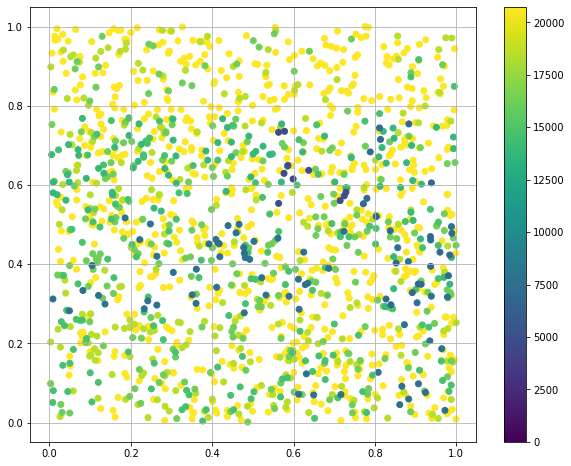

In [329]:
a = list(integ.random_batch(yield_hcube=True))

xx = a[0][0]
ww = a[0][1]
hh = a[0][2]

plt.figure(figsize=(10,8))

sc = plt.scatter(xx[:, 0], xx[:, 1], c=hh, vmin=0)
plt.colorbar(sc)

plt.grid()
plt.show()

In [328]:
hh

array([ 0,  0,  0, ..., 99, 99, 99], dtype=int64)

#### Simple

In [90]:
# try different neval (deprecated, as the larger the better, as memory limit allows)

In [87]:
# %%time
# np.random.seed(123)

# result_means = []
# result_sdevs = []
# result_times = []
# result_sum_nevals = []
# result_run_nums = []

# ndims_lst = [2,4,6,8]
# neval_lst = list(map(int, [1e5, 1e6]))  # 1e8
# nitn_lst = list(map(int, [2,4]))
# run_lst = list(range(1,1+1))

# for run in run_lst:
#     print(f'run={run}')
#     for ndims in ndims_lst:
#         integrand = dim2func_dict[ndims]
        
#         for nitn in nitn_lst:
#             for neval in neval_lst:

#                 print(f'ndims={ndims}  nitn={nitn}  neval={neval}')

#                 integ = vegas.Integrator([[0, 1]] * ndims)

#                 time_a = time.time()
#                 current_result = integ(integrand, nitn=nitn, neval=neval)
#                 total_time = time.time() - time_a

#                 result_means.append(current_result.mean)
#                 result_sdevs.append(current_result.sdev)
#                 result_times.append(total_time)
#                 result_sum_nevals.append(current_result.sum_neval)
#                 result_run_nums.append(run)

#                 # print(current_result_mean, current_result_stddev)

In [88]:
# try count ncalls

# ndims = 8

# class TestClass():
    
#     def __init__(self):
#         self.ncalls_counter = 0

#     @vegas.batchintegrand
#     def f3_np(self, x):
#         self.ncalls_counter += 1
#         return np.sin(np.sum(x, axis=-1))


# integ = vegas.Integrator([[0, 10]] * ndims, mpi=False,
#                          nhcube_batch=1e5,  # 1000 default
#                          #max_nhcube=1e9,  # 1e9 default
#                          #max_neval_hcube=1e6*10000,  # 1e6 default
#                          #max_mem=1e10  # 1e9 default
#                         )


# bb = TestClass()

# # integ(bb.f3_np, nitn=2, neval=2e9)
# current_result = integ(bb.f3_np, nitn=1, neval=1e8)

# print(current_result.summary())
# print('result = %s    Q = %.2f' % (current_result, current_result.Q))

# current_result.sum_neval, bb.ncalls_counter

In [198]:
# temp_df = pd.DataFrame({
#     'ndims': sorted(ndims_lst * len(nitn_lst) * len(neval_lst)) * len(run_lst),
#     'nitn': sorted(nitn_lst * len(neval_lst)) * len(ndims_lst) * len(run_lst),
#     'neval': sorted(neval_lst) * len(nitn_lst) * len(ndims_lst) * len(run_lst),
#     'result_mean': result_means,
#     'result_sdev': result_sdevs,
#     'total_time': result_times,
#     'sum_neval': result_sum_nevals,
#     'run_num': result_run_nums,
# })

In [89]:
# temp_df

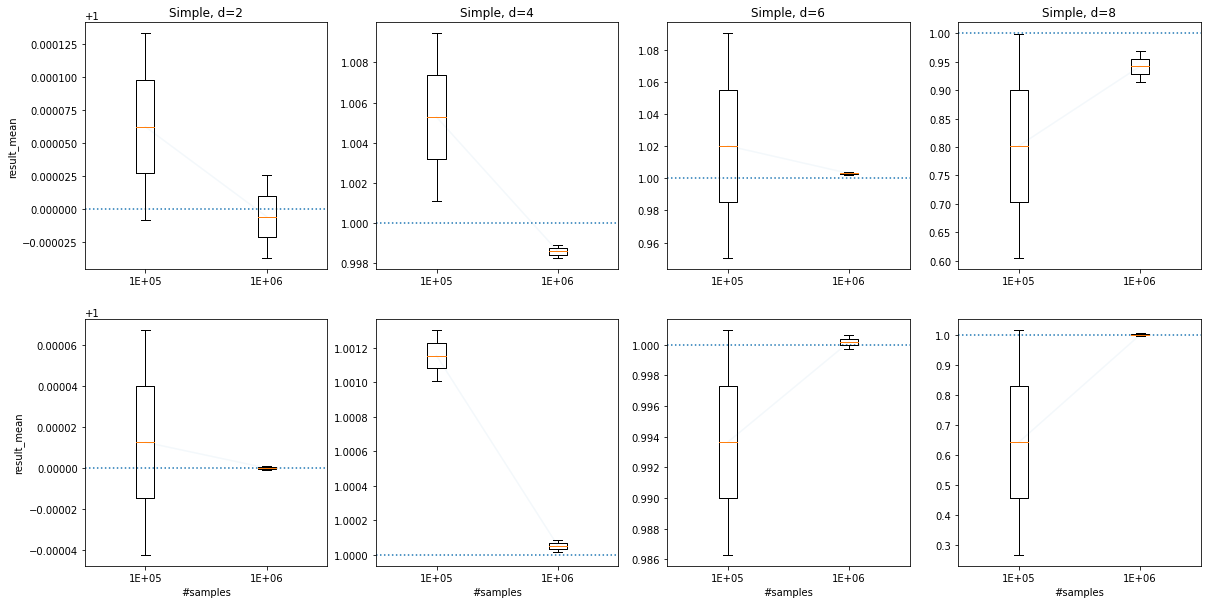

In [219]:
# result_mean vs samples for each nitn & dim

# fig = plt.figure(figsize=(20,10))

# for i, nitn in enumerate(nitn_lst):
#     for j, ndims in enumerate(ndims_lst):
#         plot_data = temp_df[(temp_df.nitn == nitn) & (temp_df.ndims == ndims)]
#         plot_data = plot_data.groupby('neval')['result_mean'].apply(lambda x: x.tolist())
#         ax = fig.add_subplot(len(nitn_lst), len(ndims_lst), i*len(ndims_lst)+j+1)
#         ax.axhline(y=target_dict[f'{func_tag}_d{ndims}'], linestyle=':')
#         ax.boxplot(plot_data, labels=[f'{x:.0E}' for x in neval_lst], showfliers=False)
#         locs = ax.get_xticks() 
#         ax.plot(locs, plot_data.apply(np.mean), linestyle='-', alpha=.05)
#         if i == 0:
#             ax.set_title(f'Simple, d={ndims}')
#         if i == len(nitn_lst)-1:
#             ax.set_xlabel('#samples')
#         if j == 0:
#             ax.set_ylabel('result_mean')

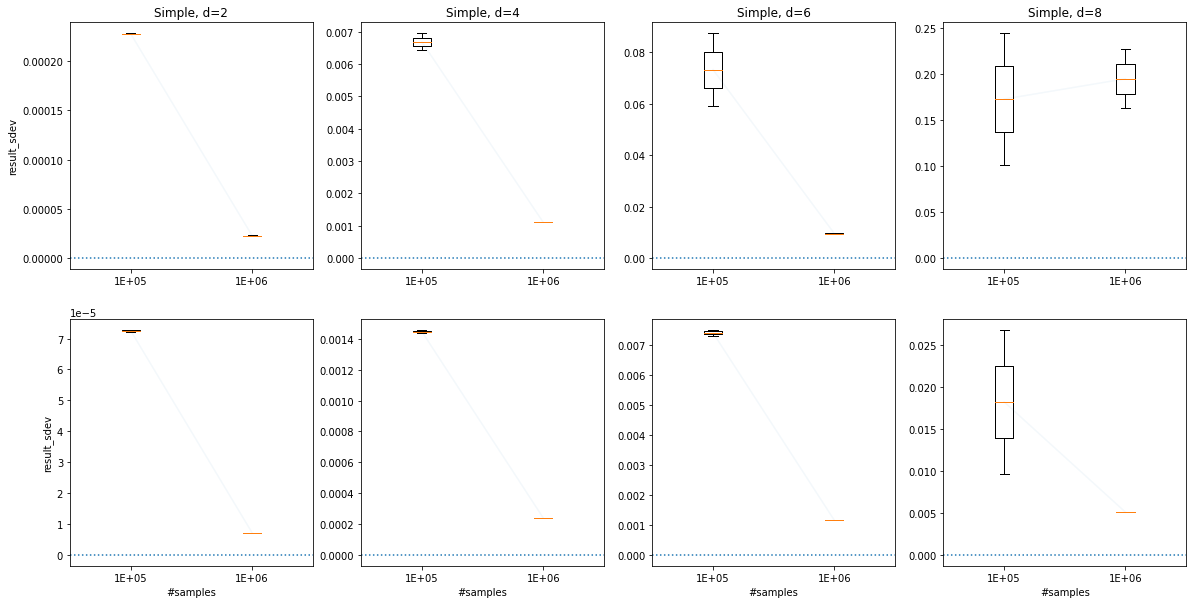

In [222]:
# # result_sdev vs samples for each nitn & dim

# fig = plt.figure(figsize=(20,10))

# for i, nitn in enumerate(nitn_lst):
#     for j, ndims in enumerate(ndims_lst):
#         plot_data = temp_df[(temp_df.nitn == nitn) & (temp_df.ndims == ndims)]
#         plot_data = plot_data.groupby('neval')['result_sdev'].apply(lambda x: x.tolist())
#         ax = fig.add_subplot(len(nitn_lst), len(ndims_lst), i*len(ndims_lst)+j+1)
#         ax.axhline(y=0, linestyle=':')
#         ax.boxplot(plot_data, labels=[f'{x:.0E}' for x in neval_lst], showfliers=False)
#         locs = ax.get_xticks() 
#         ax.plot(locs, plot_data.apply(np.mean), linestyle='-', alpha=.05)
#         if i == 0:
#             ax.set_title(f'Simple, d={ndims}')
#         if i == len(nitn_lst)-1:
#             ax.set_xlabel('#samples')
#         if j == 0:
#             ax.set_ylabel('result_sdev')

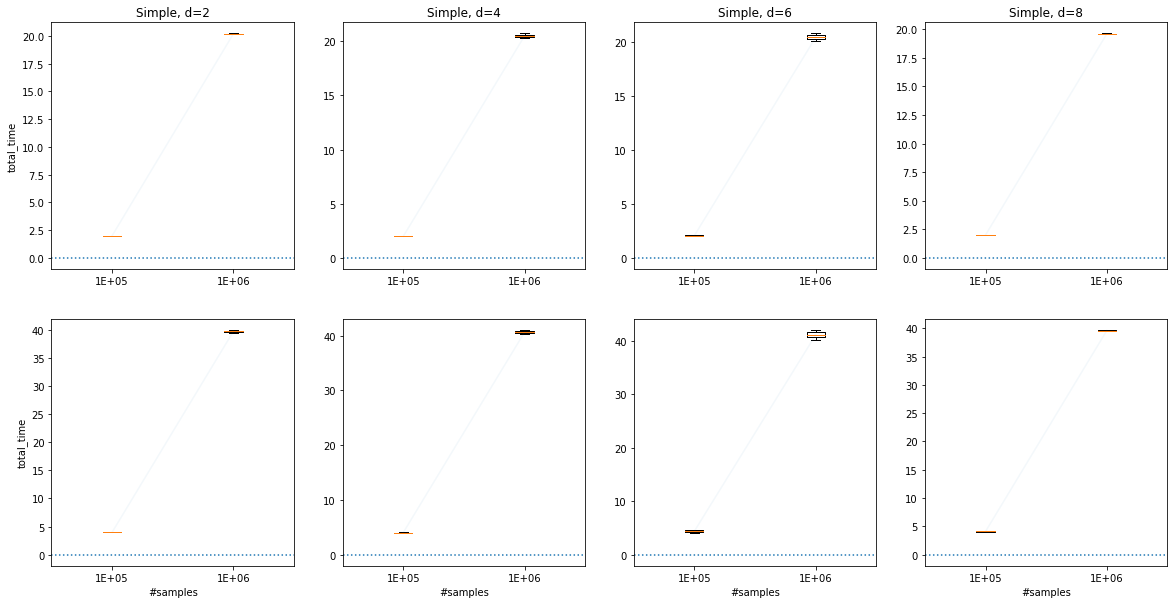

In [223]:
# # total_time vs samples for each nitn & dim

# fig = plt.figure(figsize=(20,10))

# for i, nitn in enumerate(nitn_lst):
#     for j, ndims in enumerate(ndims_lst):
#         plot_data = temp_df[(temp_df.nitn == nitn) & (temp_df.ndims == ndims)]
#         plot_data = plot_data.groupby('neval')['total_time'].apply(lambda x: x.tolist())
#         ax = fig.add_subplot(len(nitn_lst), len(ndims_lst), i*len(ndims_lst)+j+1)
#         ax.axhline(y=0, linestyle=':')
#         ax.boxplot(plot_data, labels=[f'{x:.0E}' for x in neval_lst], showfliers=False)
#         locs = ax.get_xticks() 
#         ax.plot(locs, plot_data.apply(np.mean), linestyle='-', alpha=.05)
#         if i == 0:
#             ax.set_title(f'Simple, d={ndims}')
#         if i == len(nitn_lst)-1:
#             ax.set_xlabel('#samples')
#         if j == 0:
#             ax.set_ylabel('total_time')